# Machine Learning Engineer NanoDegree
## Capstone Project

### Robots and surface recognition

Autonomous mobile robots who can move and perform tasks without human intervention, should be able to recognize the type of surface they are moving on. This was the task a group of researchers attempted to train robots to do. They supplied robots with IMU sensors that keep data on their orientation, angular velocity and linear acceleration. The task is to classify the surface the robot is moving on using the sensor data. 

As we will see below the sensor data are time series of 128-unit steps for each series. There are many ways to classify time series. I choose to do this using deep neural networks. 

In [2]:
# lead necessary libraries/modules
import keras #with tensorflow backnend
import numpy as np
import pandas as pd
import time

from keras.utils import np_utils
from sklearn.model_selection import StratifiedShuffleSplit, GroupKFold

from keras.models import Sequential, Input, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.layers import GlobalAveragePooling1D, AveragePooling1D
from keras.layers import BatchNormalization, Activation, add
from keras.layers import LeakyReLU, ELU
from keras.layers import TimeDistributed, LocallyConnected1D
from keras import regularizers, activations, initializers
from keras import layers, optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping  


from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import confusion_matrix, fbeta_score


import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy as sp

# Pretty display for notebooks
%matplotlib inline


from sklearn.metrics.classification import (_check_targets, _prf_divide,
                                            precision_recall_fscore_support)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.multiclass import unique_labels

from sklearn.base import BaseEstimator
from sklearn.externals import six
from sklearn.utils.multiclass import check_classification_targets

from sklearn.metrics import confusion_matrix, fbeta_score, f1_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, auc

from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import partial_dependence #partial_dependence.parital_dependance
                                                #partial_dependence.plot_partial_dependence

from statsmodels.tsa import stattools


print(sns.__version__)

0.9.0


In [568]:
# read in train and test sensor data
data_train = pd.read_csv('X_train.csv')
data_test = pd.read_csv('X_test.csv')
print('Shape of X_train dataset: ', data_train.shape, 'contains ', int(data_train.shape[0]/128), 'series')
print('Shape of X_test : ', data_test.shape, 'contains ', int(data_test.shape[0]/128), 'series')

data_train.head()

Shape of X_train dataset:  (487680, 13) Shape of X_test :  (488448, 13)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [4]:
# get full info on each variable
data_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487680 entries, 0 to 487679
Data columns (total 13 columns):
row_id                   487680 non-null object
series_id                487680 non-null int64
measurement_number       487680 non-null int64
orientation_X            487680 non-null float64
orientation_Y            487680 non-null float64
orientation_Z            487680 non-null float64
orientation_W            487680 non-null float64
angular_velocity_X       487680 non-null float64
angular_velocity_Y       487680 non-null float64
angular_velocity_Z       487680 non-null float64
linear_acceleration_X    487680 non-null float64
linear_acceleration_Y    487680 non-null float64
linear_acceleration_Z    487680 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 74.3 MB


In [569]:
#targets 
y_train = pd.read_csv('y_train.csv')
groups = y_train['group_id']
print('Shape of y_train : ',y_train.shape)
y_train.head()

Shape of y_train :  (3810, 3)


,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [19]:
# frequency counts per surface
y_train['surface'].value_counts()

concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64

In [33]:
# making sense of the group_id variable
y_train.groupby('group_id')['surface'].unique()

group_id
0                   [concrete]
1                      [tiled]
2                       [wood]
3                   [soft_pvc]
4                 [soft_tiles]
5                   [concrete]
6                   [soft_pvc]
7                     [carpet]
8                      [tiled]
9                 [soft_tiles]
10                      [wood]
11                     [tiled]
12                  [concrete]
13             [fine_concrete]
14                      [wood]
15                [soft_tiles]
16    [hard_tiles_large_space]
17                [soft_tiles]
18                  [soft_pvc]
19                  [soft_pvc]
20                  [concrete]
21                [soft_tiles]
22                [soft_tiles]
23                      [wood]
24                      [wood]
25                    [carpet]
26                  [soft_pvc]
27                [hard_tiles]
28                     [tiled]
29                  [soft_pvc]
                ...           
43                      [wood]

In [7]:
# number of unique group_id 
y_train.groupby('group_id')['surface'].unique().count()

73

In [9]:
# group_id per surface
y_train.groupby('surface')['group_id'].unique()

surface
carpet                                                      [25, 7, 60, 52]
concrete                  [31, 20, 12, 32, 0, 5, 62, 41, 42, 61, 57, 47,...
fine_concrete                                  [13, 35, 30, 68, 72, 36, 48]
hard_tiles                                                             [27]
hard_tiles_large_space                                 [33, 16, 59, 40, 44]
soft_pvc                  [34, 26, 3, 29, 19, 18, 6, 69, 70, 56, 53, 51,...
soft_tiles                                           [22, 21, 9, 15, 4, 17]
tiled                                    [1, 11, 8, 28, 71, 55, 54, 64, 66]
wood                        [23, 14, 10, 2, 24, 45, 49, 46, 38, 43, 65, 67]
Name: group_id, dtype: object

From the above we conclude that for each group_id correspond to only one surface and each surface has several group_ids
as if the researcher grouped sessions that were done together as one group. 

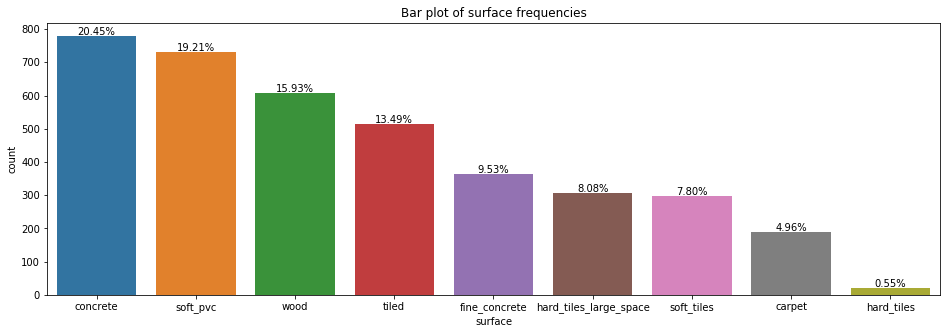

In [8]:
# bar plot of the target. 
# code borrowed from https://www.kaggle.com/gpreda/robots-need-help 

fig, ax = plt.subplots(figsize=(16,5))
total = len(y_train)
g = sns.countplot(x=y_train['surface'], order = y_train['surface'].value_counts().index)
g.set_title('Bar plot of surface frequencies')
for p in ax.patches:
    ht = p.get_height()
    ax.text(p.get_x() + p.get_width() /2, ht+3,
            '{:1.2f}%'.format(100*ht/total),
            ha="center") 
    

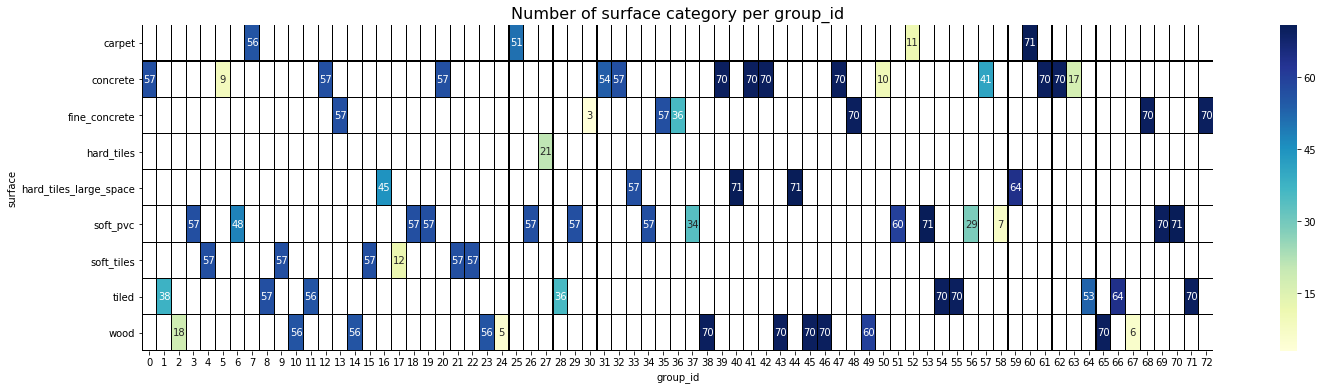

In [15]:
# A plot of surface per group_id and the count of measurements/sessions per group_id
# code from https://www.kaggle.com/gpreda/robots-need-help

fig, ax = plt.subplots(1,1,figsize=(24,6))
tmp = pd.DataFrame(y_train.groupby(['group_id', 'surface'])['series_id'].count().reset_index())
m = tmp.pivot(index='surface', columns='group_id', values='series_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of surface category per group_id', size=16)
plt.show()

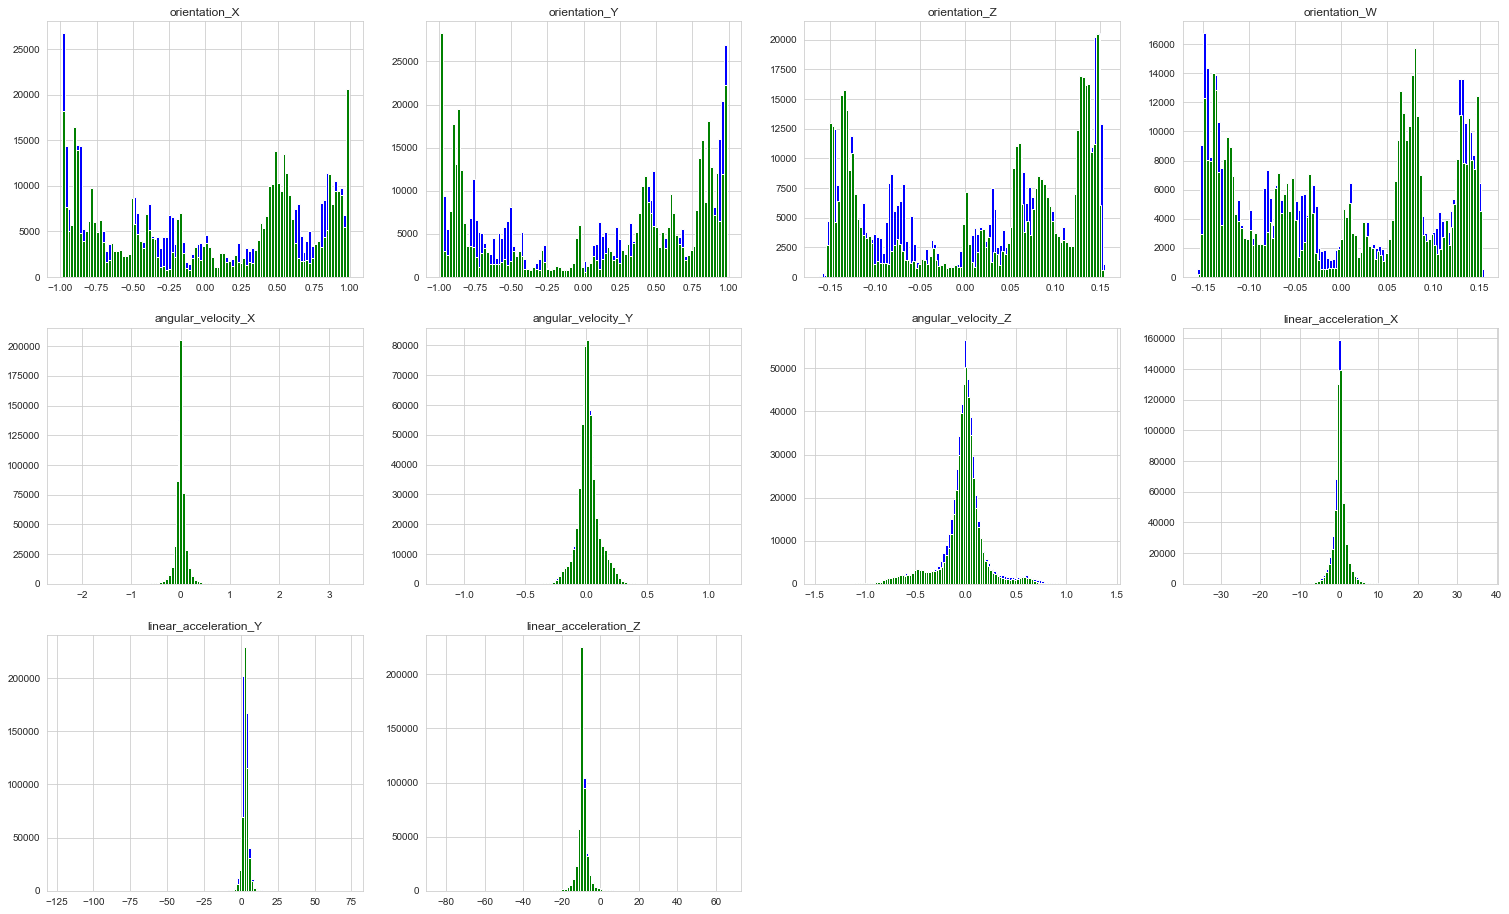

In [69]:
# histogram of each of the series variables for both train and test data
# code from https://www.kaggle.com/artgor/where-do-the-robots-drive
plt.figure(figsize=(26, 16))
for i, col in enumerate(data_train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.hist(data_train[col], color='blue', bins=100)
    plt.hist(data_test[col], color='green', bins=100)
    plt.title(col)
plt.show()

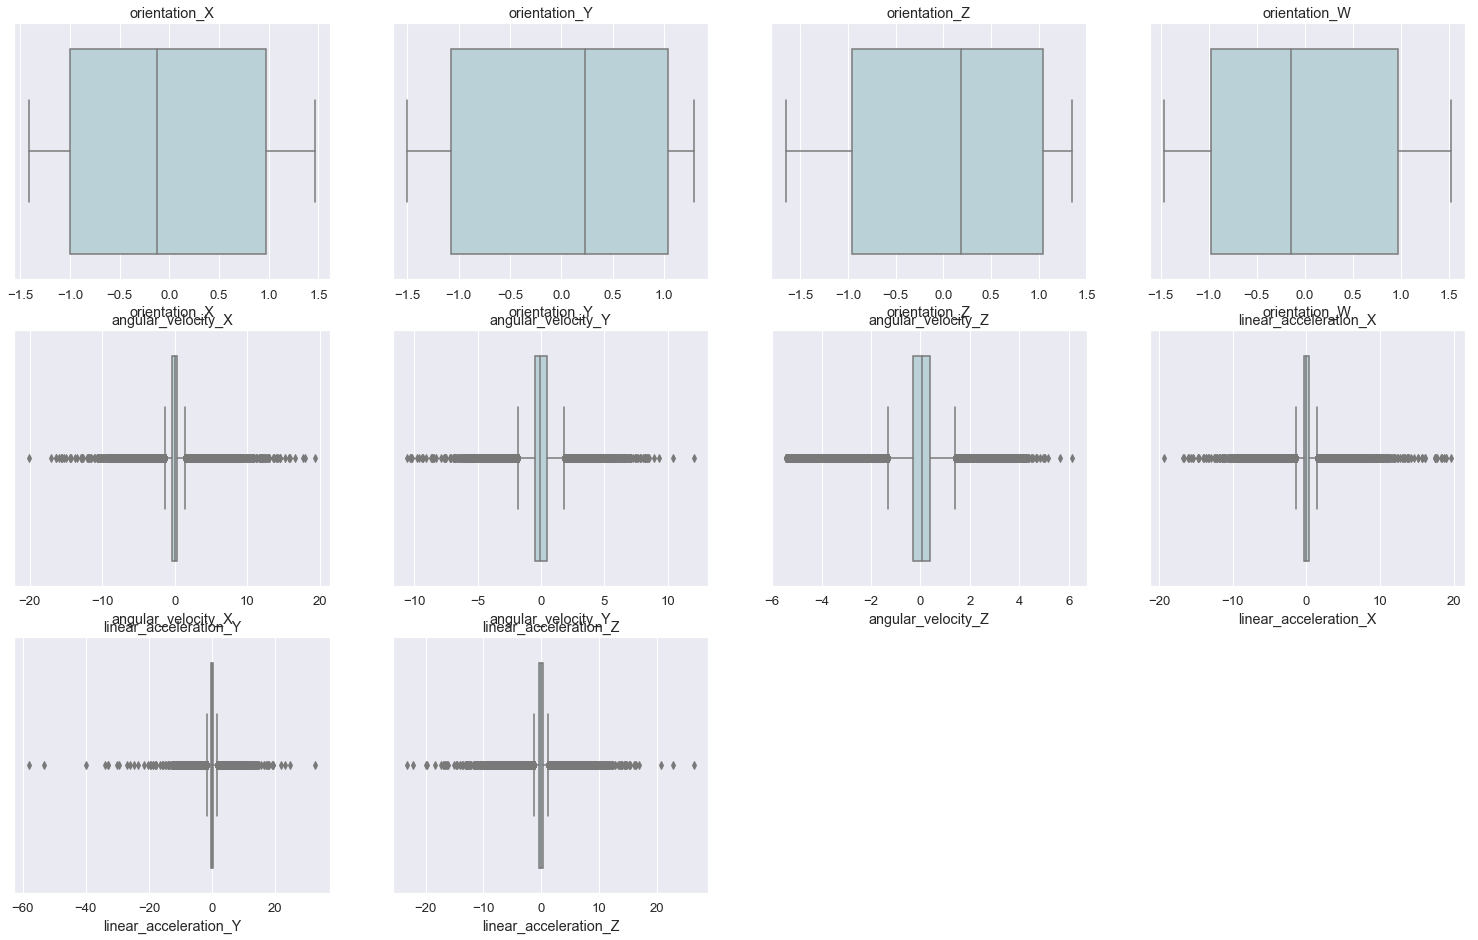

In [697]:
# boxplots of train and test data 
plt.figure(figsize=(26, 16))
for i, col in enumerate(data_train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data_train[col],color='lightblue', saturation = 0.5)
    #sns.boxplot(data_test[col], color='lightgreen', saturation = 0.5)
    plt.title(col)
plt.show()

In [315]:
data_train.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


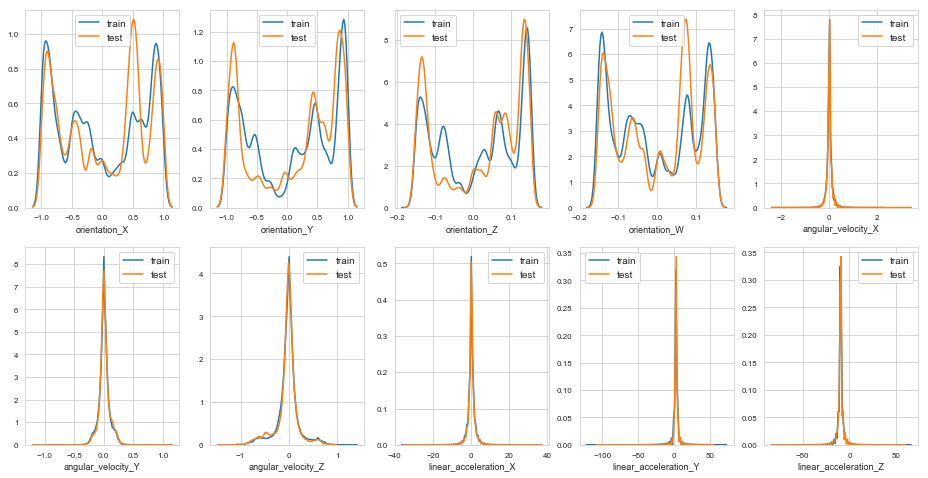

In [52]:
# Density plots of  train and test data
#https://www.kaggle.com/gpreda/robots-need-help
features = data_train.columns.values[3:13]
i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,5,figsize=(16,8))

for feature in features:
    i += 1
    plt.subplot(2,5,i)
    sns.distplot(data_train[feature], hist=False, label='train')
    sns.distplot(data_test[feature], hist=False, label='test')
    plt.xlabel(feature, fontsize=9)
    locs, labels = plt.xticks()
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)
plt.show();

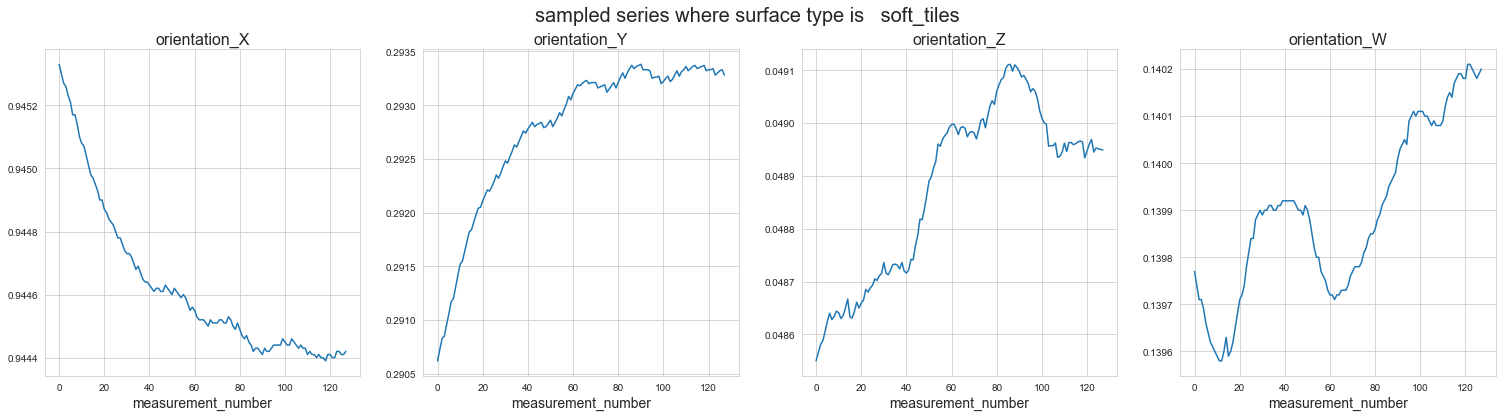

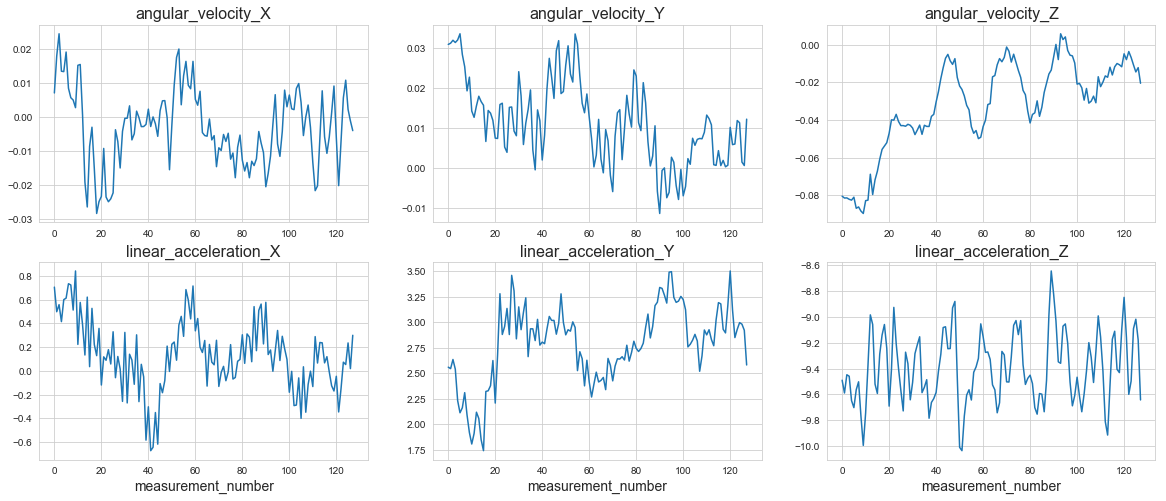

In [545]:
#sample data plots
k=406
s = (data_train['series_id'] == k)
surface_k = y_train['surface'][y_train['series_id']==k]
plt.subplots(1,4,figsize = (26,6))
plt.suptitle('sampled series where surface type is   '+surface_k.iloc[0], fontsize=20) 
for i, col in enumerate(data_train.columns[3:7]):
    plt.subplot(1,4,i+1)
    plt.plot(data_train.loc[s,'measurement_number'],data_train.loc[s,col])
    plt.xlabel("measurement_number", fontsize=14)
    plt.title(col, fontsize=16)
plt.savefig('sample_plots_1.png', dpi=200)
plt.subplots(2,3,figsize=(20,8))
for i, col in enumerate(data_train.columns[7:]):
    plt.subplot(2,3,i+1)
    plt.plot(data_train.loc[s,'measurement_number'],data_train.loc[s,col])
    if i>2:
        plt.xlabel("measurement_number", fontsize=14)
    plt.title(col, fontsize=16)
plt.savefig('sample_plots.png', dpi=200)

In [363]:
# join data and surface based on series_id so that we can plot 
# variables based on surfaces
Xy_train = data_train.join(y_train[['surface','group_id']], on='series_id')
print('shape of joined data ',Xy_train.shape)
Xy_train.head()

shape of joined data  (487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,surface,group_id
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,fine_concrete,13
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,fine_concrete,13
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,fine_concrete,13
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,fine_concrete,13
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,fine_concrete,13


In [325]:
data_by_surface = Xy_train.groupby(['surface'])


In [320]:
features_list = ['angular_velocity_X', 'angular_velocity_Y','angular_velocity_Z', 'linear_acceleration_X', 
                'linear_acceleration_Y', 'linear_acceleration_Z']

In [326]:
data_by_surface[features_list].mean()

,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
surface,,,,,,
carpet,0.001029,0.024627,-0.072238,0.091456,2.872431,-9.368058
concrete,0.000925,0.021816,-0.062718,0.111593,2.907733,-9.356408
fine_concrete,-0.000099,0.003167,-0.002443,0.136297,2.922102,-9.356070
hard_tiles,-0.000176,-0.006708,0.026448,0.145759,2.990207,-9.332681
hard_tiles_large_space,0.000434,0.016397,-0.044681,0.110250,2.885197,-9.365567
soft_pvc,0.000692,0.014869,-0.040387,0.128839,2.811946,-9.386315
soft_tiles,0.000640,0.017502,-0.048913,0.084119,2.914124,-9.359474
tiled,0.000102,0.006403,-0.012668,0.135560,2.913803,-9.357045
wood,-0.001783,-0.025233,0.089153,0.185963,2.892481,-9.364265


In [327]:
data_by_surface[features_list].std()

,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
surface,,,,,,
carpet,0.103999,0.087537,0.223227,2.033440,2.562971,2.288149
concrete,0.154918,0.097308,0.222090,2.581342,3.096531,3.726617
fine_concrete,0.085643,0.080723,0.221343,1.379338,1.601250,2.047193
hard_tiles,0.032907,0.072593,0.226314,0.521849,0.945227,0.599659
hard_tiles_large_space,0.195604,0.097617,0.188297,2.832893,2.578976,4.866550
soft_pvc,0.058173,0.057497,0.157295,0.944897,1.356420,1.235721
soft_tiles,0.030014,0.041384,0.124861,0.537524,0.872669,0.485342
tiled,0.141375,0.082908,0.165605,2.114298,2.251182,3.489906
wood,0.087131,0.116900,0.352725,1.377191,1.601598,2.134775


In [328]:
data_by_surface[features_list].max()

,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
surface,,,,,,
carpet,1.21160,0.93619,1.12570,23.2930,32.6230,22.3360
concrete,2.28220,0.83621,1.38730,36.7970,73.0080,65.8390
fine_concrete,0.71355,0.46764,0.94021,12.3940,16.4520,7.1959
hard_tiles,0.16933,0.14701,0.44347,1.8960,7.1469,-7.1307
hard_tiles_large_space,1.19500,1.07910,0.97221,24.9450,20.0050,20.4500
soft_pvc,0.86514,0.42471,0.48411,10.7160,18.5010,15.9830
soft_tiles,0.41735,0.28317,0.66076,8.8783,11.8770,-3.0539
tiled,0.95938,0.54884,0.83011,18.8060,17.9990,20.4310
wood,0.76485,0.35950,0.97238,15.0530,14.5110,12.7350


In [329]:
data_by_surface[features_list].min()

,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
surface,,,,,,
carpet,-1.05470,-0.92786,-1.24450,-29.8950,-54.5910,-49.403
concrete,-2.37100,-0.90875,-1.25930,-36.0670,-121.4900,-75.386
fine_concrete,-0.61259,-0.36092,-0.82227,-10.9300,-9.6574,-24.686
hard_tiles,-0.12939,-0.15695,-0.33992,-2.2821,-1.2135,-11.452
hard_tiles_large_space,-1.24550,-0.82208,-0.98636,-21.2210,-23.7140,-41.542
soft_pvc,-0.64247,-0.46152,-1.26880,-11.5050,-26.8300,-27.907
soft_tiles,-0.38121,-0.37008,-0.41884,-9.8046,-6.9817,-18.902
tiled,-1.02440,-0.49977,-0.77189,-16.0290,-20.9990,-37.273
wood,-0.91480,-0.52811,-0.91822,-12.5060,-10.4040,-32.114


In [167]:
#Xy_train.groupby(['surface'])['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z'].mean()
#Xy_train.groupby(['surface']).mean()
#Xy_train.groupby(['surface']).quantile(0.90)
#Xy_train.groupby(['surface']).quantile(0.50)
Xy_train.drop(['row_id', 'measurement_number','series_id'], axis=1).groupby(['surface']).min()

,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id
surface,,,,,,,,,,,
carpet,-0.98859,-0.98905,-0.15054,-0.153450,-1.05470,-0.92786,-1.24450,-29.8950,-54.5910,-49.403,7
concrete,-0.98862,-0.96579,-0.14873,-0.151860,-2.37100,-0.90875,-1.25930,-36.0670,-121.4900,-75.386,0
fine_concrete,-0.89089,-0.98866,-0.15396,-0.137720,-0.61259,-0.36092,-0.82227,-10.9300,-9.6574,-24.686,13
hard_tiles,0.46074,-0.87507,-0.12841,0.074212,-0.12939,-0.15695,-0.33992,-2.2821,-1.2135,-11.452,27
hard_tiles_large_space,-0.71222,-0.98965,-0.15189,-0.120190,-1.24550,-0.82208,-0.98636,-21.2210,-23.7140,-41.542,16
soft_pvc,-0.97853,-0.91465,-0.16283,-0.147770,-0.64247,-0.46152,-1.26880,-11.5050,-26.8300,-27.907,3
soft_tiles,-0.96457,-0.96176,-0.14454,-0.147440,-0.38121,-0.37008,-0.41884,-9.8046,-6.9817,-18.902,4
tiled,-0.98910,-0.98908,-0.15101,-0.156620,-1.02440,-0.49977,-0.77189,-16.0290,-20.9990,-37.273,1
wood,-0.98872,-0.98883,-0.15023,-0.153400,-0.91480,-0.52811,-0.91822,-12.5060,-10.4040,-32.114,2


C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


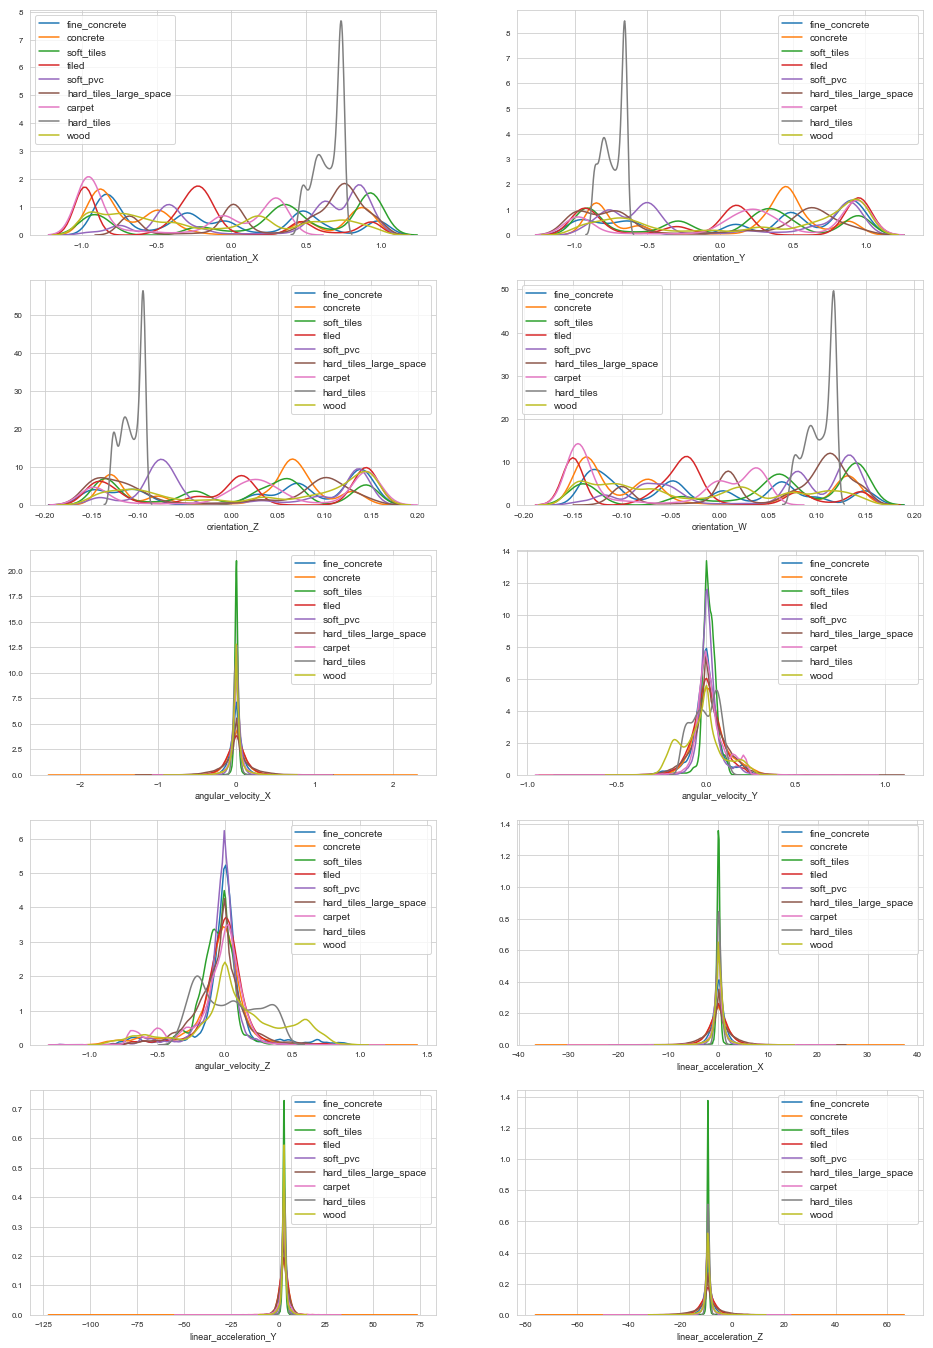

In [536]:
# density plots of each variable and each surface
#https://www.kaggle.com/gpreda/robots-need-help
classes = (y_train['surface'].unique())
i = 0
sns.set_style('whitegrid')

fig, ax = plt.subplots(5,2,figsize=(16,24))

for feature in Xy_train.columns[3:13]:
    i += 1
    plt.subplot(5,2,i)
    for clas in classes:
        ttc = Xy_train[Xy_train['surface']==clas]
        sns.distplot(ttc[feature], hist=False,label=clas)
    plt.xlabel(feature, fontsize=9)
    locs, labels = plt.xticks()
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)

#fig = plt.gcf()
#fig.set_size_inches(18.5, 10.5)
plt.savefig('density_by_class.png', dpi=100)

tiled
9
[28, 64]
(128, 15)


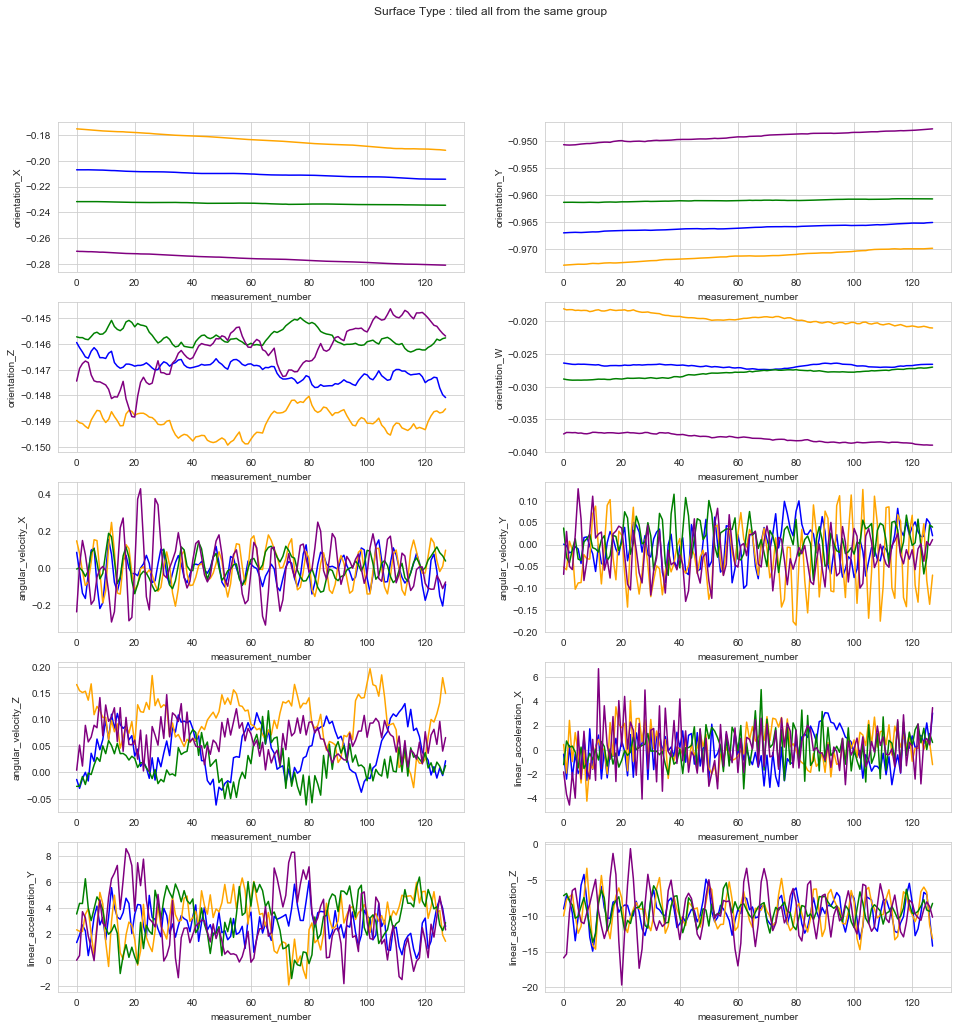

In [368]:
# ploting samples of time-series for fixed surfaces and group_id
surfaces = list(y_train['surface'].unique())
#sample one surface type
surface = random.sample(surfaces,1)[0]
#print(surface)
#print(y_train.loc[y_train['surface'] == surface, 'group_id'].nunique())

#sample one group for the choosen sample
grp = random.sample(list(y_train.loc[y_train['surface'] == surface, 'group_id'].unique()),2)
#print(grp)

#sample 10 series from the group 
series_sample = random.sample(list(y_train.loc[(y_train['surface']==surface) & (y_train['group_id']== grp[0]),'series_id']),10)

#create data frames for each samples series
sample_df = Xy_train[(Xy_train['series_id'] == series_sample[0])]
sample_df2 = Xy_train[(Xy_train['series_id'] == series_sample[1])]
sample_df3 = Xy_train[(Xy_train['series_id'] == series_sample[2])]
sample_df4 = Xy_train[(Xy_train['series_id'] == series_sample[4])]

#plot these all together to see how similar the features are when they belong to the same group
plt.subplots(5,2,figsize=(16,16))
plt.suptitle('Surface Type : ' + surface+' all from the same group')
for i,col in enumerate(data_train.columns[3:13]):
    plt.subplot(5,2,i+1)
    plt.plot(sample_df['measurement_number'], sample_df[col], color='blue')
    plt.plot(sample_df2['measurement_number'], sample_df2[col], color='orange')
    plt.plot(sample_df3['measurement_number'], sample_df3[col], color='green')
    plt.plot(sample_df4['measurement_number'], sample_df4[col], color='purple')
    #plt.title(surface)
    plt.ylabel(col)
    plt.grid(True)
    plt.xlabel('measurement_number')

plt.show()

**Plots by surface**: below I wish to plot samples from each series to inspect whether there are differences. 

I start by joining X and y data on `series_id` so that I have `surface` type in one data frame. Next, I sample one series corresponding to each of the nine surfaces. Then I apply a slightly smooth out the noise using a 7-point moving average. 
Finally I create data frames for each set of orientation, velocity and acceleration features and reshape them so that I can use `sns.FacetGrid`. I find this to be an easy way to arrange plots with one common legend for all plots. 

In [584]:
# join data and surface based on series_id so that we can plot 
# variables based on surfaces
Xy_train = data_train.join(y_train[['surface','group_id']], on='series_id')

#def plot_sample_from_each_class(data_train, y_train):
# choose one series from each class
class_sample = []
for clas in classes:
    class_sample.append(random.sample(list(Xy_train[Xy_train['surface']== clas]['series_id']),k=1)[0])

In [585]:
# define a sample where one series is sampled from each class
#initialize df using first series/class
sample_df = Xy_train[Xy_train['series_id'] == class_sample[0]]
#add in the remaining series/classes
for k in class_sample[1:]:
    result = pd.concat([sample_df, Xy_train[Xy_train['series_id'] == k]])
    sample_df = result
 

In [372]:
## Moving average section (7-point/unit/step) 
#--------------------------
def moving_average_7(ser):
    mav=np.zeros((128,))
    mav[0]=np.mean(ser[0:4])
    mav[1]=np.mean(ser[0:5])
    mav[2]=np.mean(ser[0:6])
    for i in range(3,128-4):
        mav[i] = np.mean(ser[(i-3):(i+4)])
    mav[124] = np.mean(ser[121:128])
    mav[125] = np.mean(ser[122:128])
    mav[126] = np.mean(ser[123:128])
    mav[127] = np.mean(ser[124:128])
    return mav

In [586]:
#apply the smoothing moving average

N = int(sample_df.shape[0]/128)
print(N)
smooth_sample_df = sample_df
for k in range(N):
    for j in range(3,13):
        lower = k*128
        upper = (k+1)*128
        ser = sample_df.iloc[lower:upper, j]
        smooth_sample_df.iloc[lower:upper,j] = moving_average_7(ser)

9


In [587]:
# select features and melt 
# (melting all features into two columns one for feature name and one for corresponing value)

#orientation
smooth_long_sample_o_df = smooth_sample_df[['series_id', 'measurement_number','surface','orientation_X', 
                                            'orientation_Y', 'orientation_Z', 'orientation_W']]
smooth_long_sample_o_df = smooth_long_sample_o_df.melt(id_vars= ['series_id','measurement_number','surface'], 
                                                       var_name='feature')

#velocity
smooth_long_sample_v_df = smooth_sample_df[['series_id', 'measurement_number','surface', 'angular_velocity_X', 
                                         'angular_velocity_Y', 'angular_velocity_Z']]
smooth_long_sample_v_df = smooth_long_sample_v_df.melt(id_vars= ['series_id','measurement_number','surface'], 
                                                       var_name='feature')

#acceleration
smooth_long_sample_a_df = smooth_sample_df[['series_id', 'measurement_number','surface','linear_acceleration_X', 
                                         'linear_acceleration_Y', 'linear_acceleration_Z']]
smooth_long_sample_a_df = smooth_long_sample_a_df.melt(id_vars= ['series_id','measurement_number','surface'], 
                                                       var_name='feature')

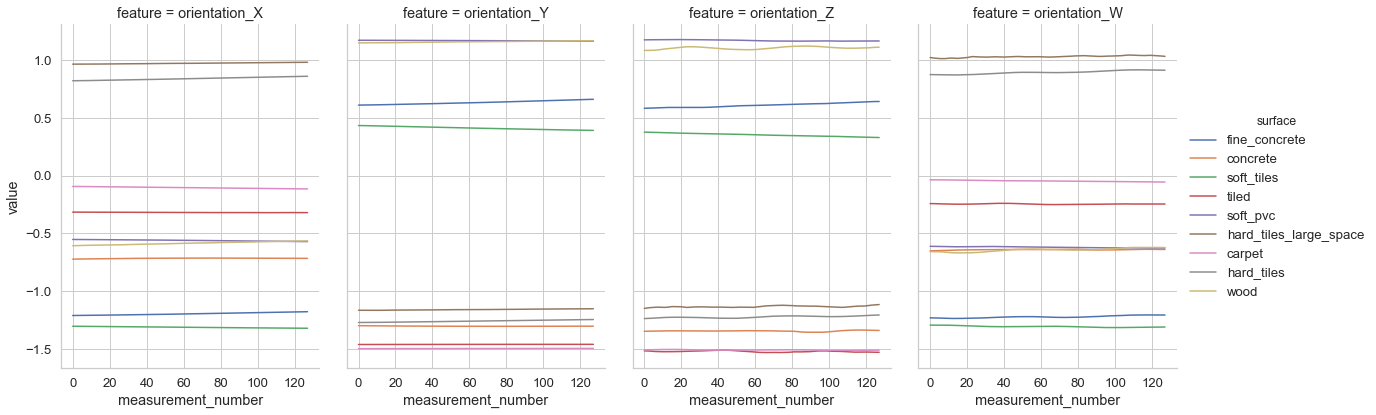

In [588]:
#orientation plots by surface
sns.set_style('whitegrid')
grid = sns.FacetGrid(smooth_long_sample_o_df, col='feature', hue='surface', col_wrap=4, height=6, aspect=.7)
grid.map(plt.plot, "measurement_number", "value")
grid.set(xticks=range(0,129,20))
grid.add_legend()
sns.set(font_scale=1.2)
plt.savefig('orin_by_clas.png', dpi=200)
plt.show()

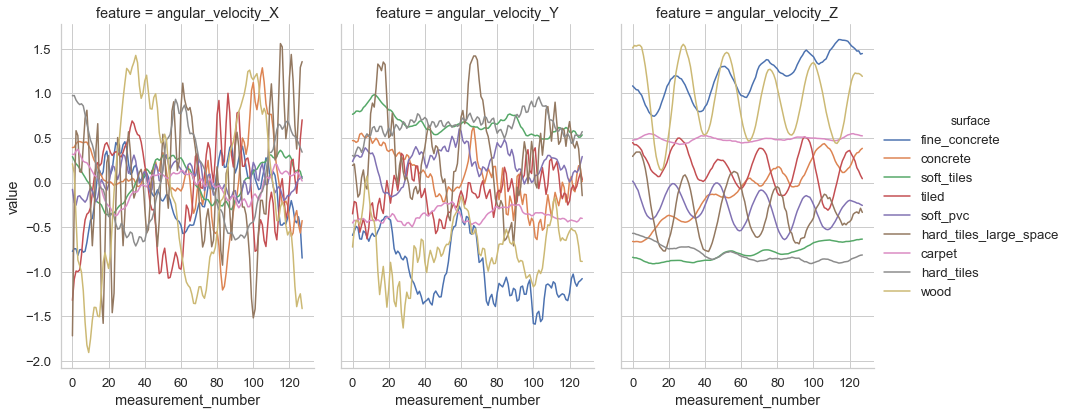

In [589]:
#velocity plots by surface

sns.set_style('whitegrid')
grid = sns.FacetGrid(smooth_long_sample_v_df, col='feature', hue='surface', col_wrap=3, height=6, aspect=.7)
grid.map(plt.plot, "measurement_number", "value")
grid.set(xticks=range(0,129,20))
grid.add_legend()
sns.set(font_scale=1.2)
#plt.savefig('vel_by_clas.png', dpi=200)
plt.show()

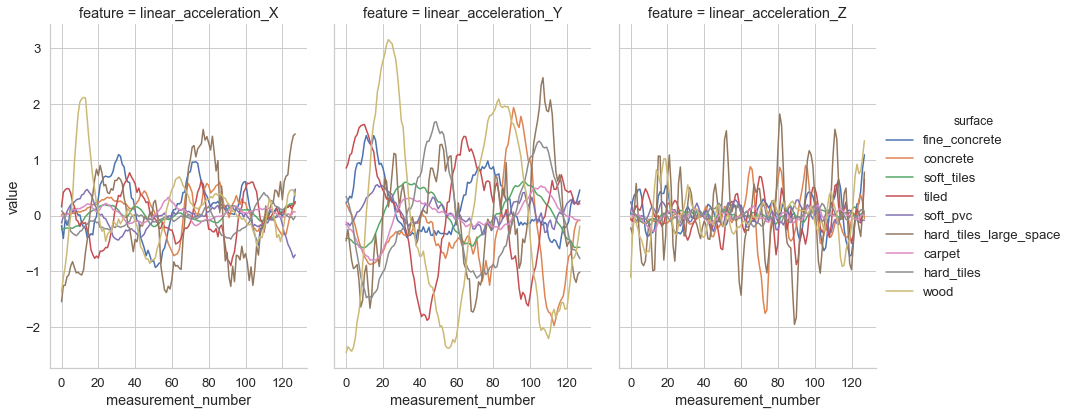

In [590]:
# acceleration plots by surface

sns.set_style("whitegrid")
grid = sns.FacetGrid(smooth_long_sample_a_df, col='feature', hue='surface', col_wrap=3, height=6, aspect=.7)
grid.map(plt.plot, "measurement_number", "value")
grid.set(xticks=range(0,129,20))
grid.add_legend()
sns.set(font_scale=1.5)
#plt.savefig('acc_by_clas.png', dpi=200)
plt.show()

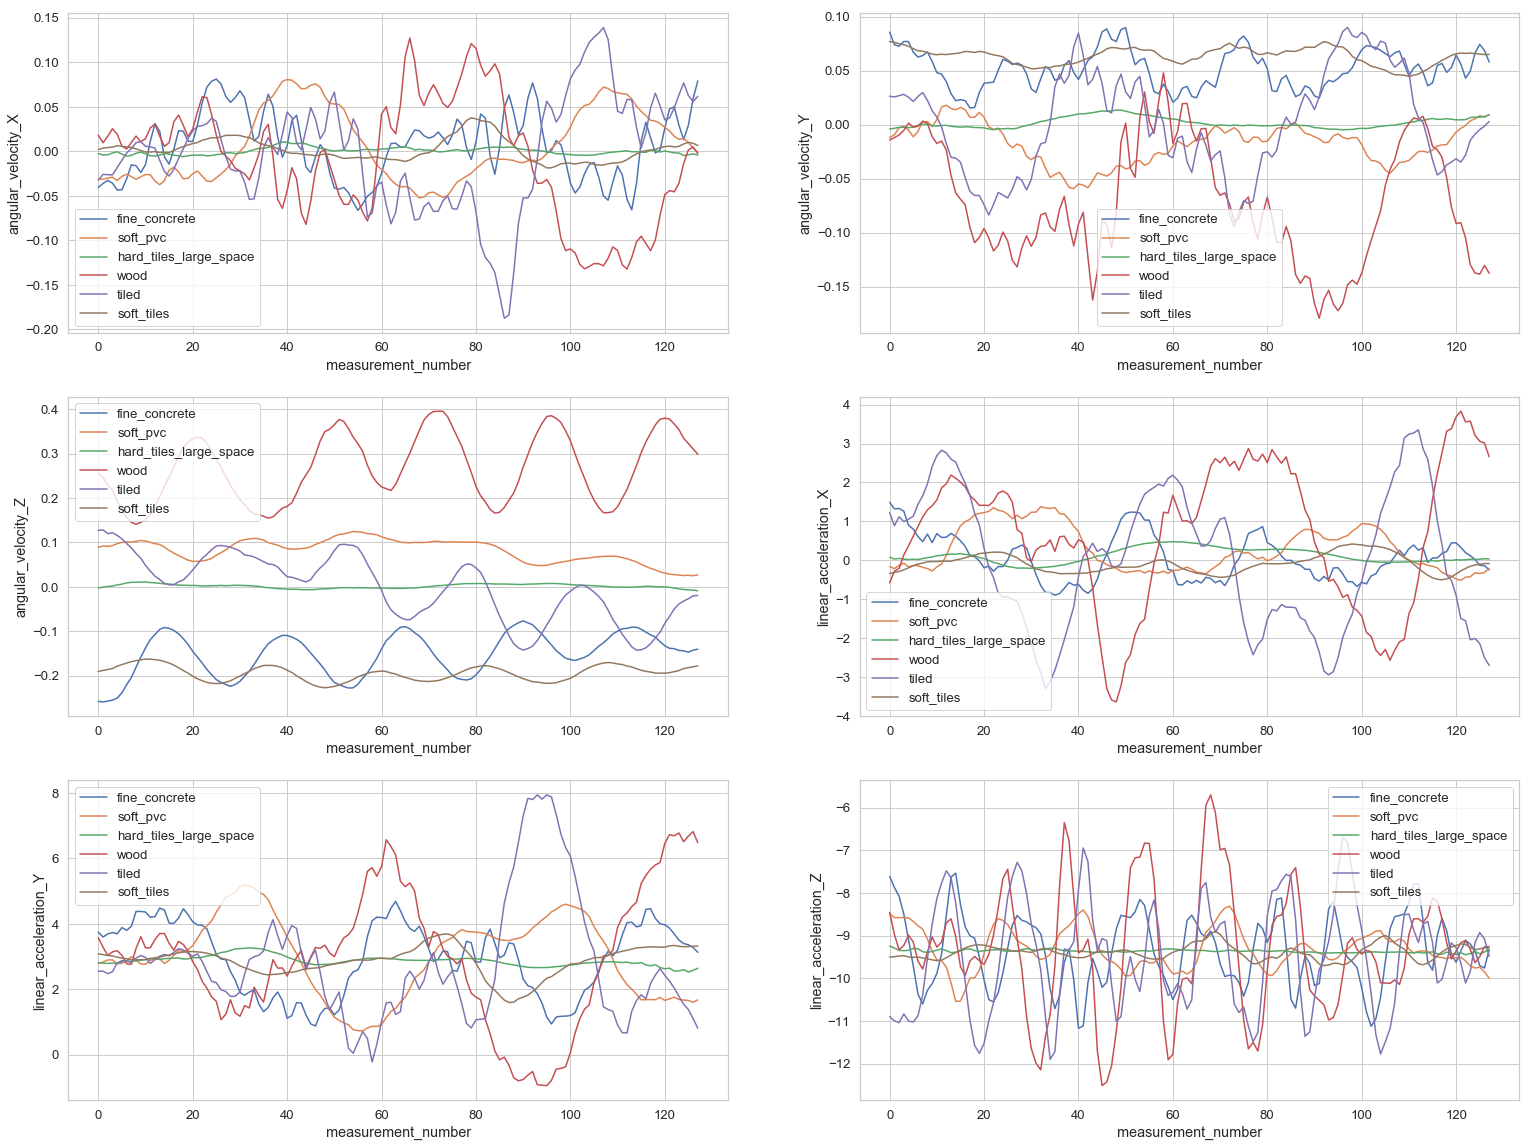

In [560]:

# plots of randomly sampled series
sns.set_style('whitegrid')
plt.subplots(3,2,figsize=(26,20))
for i, feature in enumerate(smooth_sample_df.columns[7:13]):
    plt.subplot(3,2,i+1)
    for clas in sample_classes:
        #print(clas)
        clas_slice = smooth_sample_df[smooth_sample_df['surface']== clas]
        #print(clas_slice.shape)
        plt.plot(clas_slice['measurement_number'],clas_slice[feature], label=clas)
        plt.ylabel(feature)
        plt.xlabel("measurement_number")
        plt.legend()

plt.show()

In [10]:
# from the above we observe that orientation variables where spread
# we scale the variables by z-normalize
# code from https://www.kaggle.com/artgor/where-do-the-robots-drive

#for col in data_train.columns:
#    # rescale orientation variables only
#    if 'orient' in col:
#        scaler = StandardScaler()
#        data_train[col] = scaler.fit_transform(data_train[col].values.reshape(-1, 1))
#        data_test[col] = scaler.transform(data_test[col].values.reshape(-1, 1))


In [583]:
# from the above I find it better to scale all features by z-normalizing
for col in data_train.columns[3:]:
    scaler = StandardScaler()
    data_train[col] = scaler.fit_transform(data_train[col].values.reshape(-1, 1))
    data_test[col] = scaler.transform(data_test[col].values.reshape(-1, 1))

Preparing data for convolutional neural networks we need to reshape the data to a three-dimensional array.
We do this for the full data and the also grouping orientation, velocity and acceleration variables separately.

In [591]:
#use pd.DataFrame.groupby to group by series_id and collect important variables
tr = np.array([x.values[:,3:] for group,x in data_train.groupby('series_id')], dtype='float32')
tr_orient = np.array([x.values[:,3:7] for group,x in data_train.groupby('series_id')], dtype='float32')
tr_velocity = np.array([x.values[:,7:10] for group,x in data_train.groupby('series_id')], dtype='float32')
tr_acceler = np.array([x.values[:,10:13] for group,x in data_train.groupby('series_id')], dtype='float32')
tr_vel_acc = np.array([x.values[:,7:13] for group,x in data_train.groupby('series_id')], dtype='float32')
print('shape of tr_orient ', tr_orient.shape)

shape of tr_orient  (3810, 128, 4)


In [19]:
#use pd.DataFrame.groupby to group by series_id and collect important variables
tr = np.array([x.values[:,3:] for group,x in data_train.groupby('series_id')], dtype='float32')
tr_orient = np.array([x.values[:,3:7] for group,x in data_train.groupby('series_id')], dtype='float32')
tr_velocity = np.array([x.values[:,7:10] for group,x in data_train.groupby('series_id')], dtype='float32')
tr_acceler = np.array([x.values[:,10:13] for group,x in data_train.groupby('series_id')], dtype='float32')
tr_vel_acc = np.array([x.values[:,7:13] for group,x in data_train.groupby('series_id')], dtype='float32')
print('shape of tr_orient ', tr_orient.shape)

shape of tr_orient  (3810, 128, 4)


In [592]:
# reshape test data as above
ts = np.array([x.values[:,3:] for group,x in data_test.groupby('series_id')], dtype='float32')
ts.shape
ts_orient = np.array([x.values[:,3:7] for group,x in data_test.groupby('series_id')], dtype='float32')
ts_velocity = np.array([x.values[:,7:10] for group,x in data_test.groupby('series_id')], dtype='float32')
ts_acceler = np.array([x.values[:,10:13] for group,x in data_test.groupby('series_id')], dtype='float32')
ts_vel_acc = np.array([x.values[:,7:13] for group,x in data_test.groupby('series_id')], dtype='float32')

## Target and spliting strategy by groups

The `y_train` data has `series_id`, `group_id` and `surface` variables. For each data 
We encode the surfaces as targets and then transform it to one-hot encoder, so that we apply 'softmax' activation function as the final layer of deep learning scheme. 

Each `surface` is split among several `group_id`s, which indicates that there could be some correlation between series within the same group. In order to have a good validation of the training phase, it would be better to split those signals that where training together (within the same group) from othere collected from a different group. So that we split the training and validating data by group.   


In [593]:
seed = 27
np.random.seed(seed)

num_classes = len(np.unique(y_train['surface']))

# labeling the surfaces with integers
le = LabelEncoder()
targets = le.fit_transform(y_train['surface'])

# one-hot encode the labels
targets_enc = np_utils.to_categorical(targets, num_classes)

In [73]:
### the possibility that group_id indicate runs that are done together allows for correlerations
# that are not accounted for. This is a problem for this data collection method.
# Each group_id represent one surface. 
# I propose to classify into group_id and then map to surface 
# 

# number of group_id's
num_groups = len(np.unique(y_train['group_id']))

#group_id are integers
# one-hot encode these
target_grp = np_utils.to_categorical(y_train['group_id'], num_groups)

grp_surface = y_train.groupby('group_id')['surface'].unique()
grp_surface.shape
grp_surface_dict = {i : grp_surface[i][0] for i in range(len(grp_surface))}

pd.Series([1,2,3]).map(grp_surface_dict)

Below we use `GroupKFold` to split data for cross validation. I examine each fold, for surface types and `group_id` 

In [32]:
# Split data to train and validation sets by group_id
groups = y_train['group_id']
gkf = GroupKFold(n_splits=6)
random.seed(27)
i=0
for train_index, valid_index in gkf.split(tr, targets, groups):
    i += 1
    print('Fold ',i)
    print('train index : ', len(train_index))
    print('valid index : ', len(valid_index))
    gl = []
    sl = []
    glt = []
    slt = []
    for j in train_index:
        slt.append(y_train.loc[j,'surface']) #list of surfaces in training folds
        glt.append(y_train.loc[j,'group_id']) #list of groups in training folds
    print('surface train list ', np.unique(slt), 'with', len(np.unique(slt)),' surfaces')
    print('group train list ', np.unique(glt), len(glt))
    for k in valid_index:
        sl.append(y_train.loc[k,'surface']) #list of surfaces in validation fold
        gl.append(y_train.loc[k,'group_id']) #list of groups in validation fold
    print('surface valid list ', np.unique(sl), 'with ', len(np.unique(sl)),'surfaces')
    print('group valid list ', np.unique(gl), 'with ',len(gl),'total series')
    print('+++++++++++++++++++++++++++++++++++++++++++++')

Fold  1
train index :  3174
valid index :  636
surface train list  ['carpet' 'concrete' 'fine_concrete' 'hard_tiles' 'hard_tiles_large_space'
 'soft_pvc' 'soft_tiles' 'tiled' 'wood'] with 9  surfaces
group train list  [ 1  2  3  4  5  7  8  9 10 11 13 15 16 18 19 20 21 22 23 24 26 27 28 29
 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47 48 50 51 53 55 56 57 58
 59 60 61 63 64 65 66 67 68 69 71 72] 3174
surface valid list  ['carpet' 'concrete' 'fine_concrete' 'soft_pvc' 'soft_tiles' 'tiled'
 'wood'] with  7 surfaces
group valid list  [ 0  6 12 14 17 25 30 43 49 52 54 62 70] with  636 total series
+++++++++++++++++++++++++++++++++++++++++++++
Fold  2
train index :  3177
valid index :  633
surface train list  ['carpet' 'concrete' 'fine_concrete' 'hard_tiles_large_space' 'soft_pvc'
 'soft_tiles' 'tiled' 'wood'] with 8  surfaces
group train list  [ 0  2  3  4  6  7  8 11 12 13 14 15 16 17 18 21 22 23 24 25 26 28 29 30
 31 33 34 35 36 37 38 39 40 41 42 43 46 47 48 49 50 51 52 53 54 56 57 58

## Benchmark 

We use random forests classification on aggregate statistics of each series rather than the full series them selves for the classification task

In [594]:
def benchmark_feature_engineering(bn_data_train):
    featre = pd.DataFrame()
    for i, col in enumerate(bn_data_train.columns[3:]):
        featre[col+'_min'] = bn_data_train.groupby('series_id')[col].min()
        featre[col+'_max'] = bn_data_train.groupby(['series_id'])[col].max()
        featre[col+'_mean'] = bn_data_train.groupby(['series_id'])[col].mean()
        featre[col+'_std'] = bn_data_train.groupby(['series_id'])[col].std()

        featre[col+'_25perc'] = bn_data_train.groupby(['series_id'])[col].quantile(0.25)
        featre[col+'_50perc'] = bn_data_train.groupby(['series_id'])[col].quantile(0.50)
        featre[col+'_75perc'] = bn_data_train.groupby(['series_id'])[col].quantile(0.75)
        featre[col+'_90perc'] = bn_data_train.groupby(['series_id'])[col].quantile(0.90)
        featre[col+'_95perc'] = bn_data_train.groupby(['series_id'])[col].quantile(0.95)

        featre[col+'_abs_max'] = bn_data_train.groupby('series_id')[col].apply(lambda x : np.max(np.abs(x)))
        featre[col+'_abs_min'] = bn_data_train.groupby('series_id')[col].apply(lambda x : np.min(np.abs(x)))

        featre[col+'_range'] = featre[col+'_max'] - featre[col+'_min'] #np.ptp is max-min
        featre[col+'_abs_range'] = featre[col+'_abs_max'] - featre[col+'_abs_min']
        featre[col+'_iqr'] = featre[col+'_75perc'] - featre[col+'_25perc'] # 75perc - 25perc
        
    return featre

In [595]:
# reload data for benchmark model operation
benchmark_data_train = pd.read_csv('X_train.csv')
benchmark_data_test = pd.read_csv('X_test.csv')

In [597]:
# from the above I find it better to scale all features by z-normalizing
for col in data_train.columns[3:]:
    scaler = StandardScaler()
    benchmark_data_train[col] = scaler.fit_transform(benchmark_data_train[col].values.reshape(-1, 1))
    benchmark_data_test[col] = scaler.transform(benchmark_data_test[col].values.reshape(-1, 1))

In [598]:
# prepare aggregate data 
aggreg_all_data = benchmark_feature_engineering(benchmark_data_train)
aggreg_all_data.head()

,orientation_X_min,orientation_X_max,orientation_X_mean,orientation_X_std,orientation_X_25perc,orientation_X_50perc,orientation_X_75perc,orientation_X_90perc,orientation_X_95perc,orientation_X_abs_max,...,linear_acceleration_Z_25perc,linear_acceleration_Z_50perc,linear_acceleration_Z_75perc,linear_acceleration_Z_90perc,linear_acceleration_Z_95perc,linear_acceleration_Z_abs_max,linear_acceleration_Z_abs_min,linear_acceleration_Z_range,linear_acceleration_Z_abs_range,linear_acceleration_Z_iqr
series_id,,,,,,,,,,,,,,,,,,,,,
0,-1.081355,-1.079445,-1.080095,0.000529,-1.080477,-1.079897,-1.079660,-1.079488,-1.079474,1.081355,...,-0.179579,-0.022867,0.257073,0.476360,0.641785,1.106060,0.005242,2.194432,1.100818,0.436653
1,-1.372199,-1.371338,-1.371683,0.000221,-1.371849,-1.371666,-1.371499,-1.371407,-1.371367,1.372199,...,-0.399202,-0.017191,0.393964,0.804036,1.278609,2.658072,0.002887,4.984680,2.655185,0.793166
2,-0.723777,-0.716631,-0.720448,0.002009,-0.721983,-0.720415,-0.718829,-0.717576,-0.717215,0.723777,...,-0.239643,-0.003344,0.270183,0.447966,0.650705,1.272497,0.000567,2.373988,1.271930,0.509825
3,-1.344081,-1.342856,-1.343336,0.000332,-1.343585,-1.343337,-1.343031,-1.342885,-1.342871,1.344081,...,-0.802932,0.071410,0.600354,1.430127,2.010130,3.683258,0.032785,6.778069,3.650472,1.403287
4,-1.281677,-1.266860,-1.273526,0.004310,-1.277164,-1.273000,-1.269806,-1.267972,-1.267484,1.281677,...,-0.185616,0.011277,0.186019,0.384976,0.528500,0.673342,0.002912,1.239220,0.670430,0.371634


In [599]:
# compute correlation of engineered features with class labels

cor_with_class = []
for col in aggreg_all_data.columns:
    cor_with_class.append(np.corrcoef(targets,aggreg_all_data[col])[1,0])

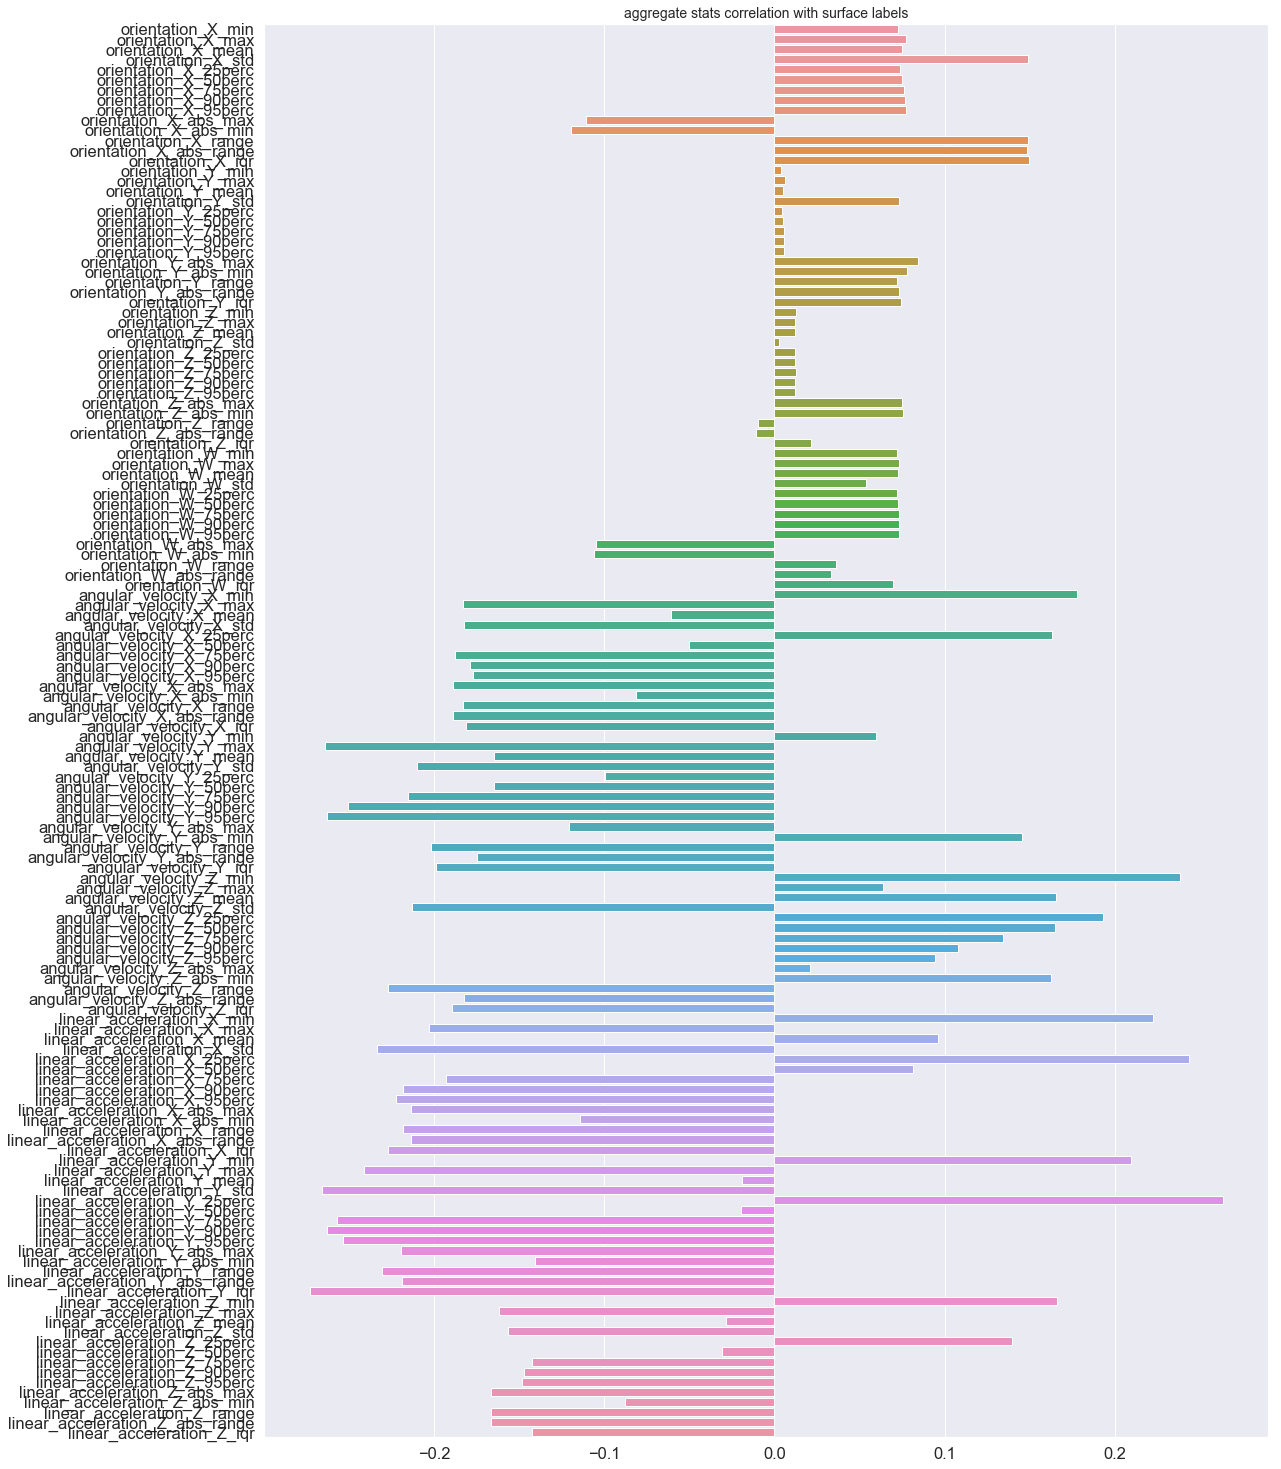

In [600]:
#plot correlations
cor_with_class = np.array(cor_with_class).reshape(140)

plt.figure(figsize=(18,26))
sns.barplot(x=cor_with_class, y=aggreg_all_data.columns)
plt.title('aggregate stats correlation with surface labels', fontsize = 14)
plt.show()

observe above the correlations are stongest with velocity and acceleration features than orientation.

In [601]:
#splitting with no regard to group_id
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state = 27)


RF_clf = RandomForestClassifier(n_estimators = 150, random_state = 27)

#initialize holder of all validated predictions
pred_val_1 = np.zeros((targets.shape[0],9))

acc_scores1 = []
f1_scores1 = []

i=0
for train_index, valid_index in skf.split(aggreg_all_data, targets):
    i += 1
    print('Fold: ', i)
    X_train, X_valid = aggreg_all_data.iloc[train_index], aggreg_all_data.iloc[valid_index]
    y_train, y_valid = targets_enc[train_index], targets_enc[valid_index]
    RF_clf.fit(X_train, y_train)
    pred = RF_clf.predict(X_valid)
    pred_val_1[valid_index] = pred
    acc_scr = accuracy_score(pred, y_valid)
    f1_scr = f1_score(pred,y_valid, average='macro')
    
    acc_scores1.append(acc_scr)
    f1_scores1.append(f1_scr)
    print('Fold {}, acc: {:.4f}, f1 score {:.4f}'.format(i, acc_scr, f1_scr))
    

Fold:  1
Fold 1, acc: 0.7872, f1 score 0.8259
Fold:  2
Fold 2, acc: 0.7759, f1 score 0.8007
Fold:  3
Fold 3, acc: 0.7520, f1 score 0.7775
Fold:  4


C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Fold 4, acc: 0.8009, f1 score 0.7607
Fold:  5


C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Fold 5, acc: 0.7737, f1 score 0.7459
Fold:  6
Fold 6, acc: 0.7940, f1 score 0.7556


C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [603]:

aggreg_all_test = benchmark_feature_engineering(benchmark_data_test)
y_test_pred = RF_clf.predict(aggreg_all_test)

In [604]:
submission = pd.read_csv('sample_submission.csv')
submission['surface'] = le.inverse_transform(np.argmax(y_test_pred, axis=1))
submission.to_csv('submission_RF_skf.csv', index=False)

In [605]:
submission.to_csv('submission_RF_skf.csv', index=False)

In [602]:
accuracy_score(np.argmax(pred_val_1, axis=1), targets)
#f1_score(np.argmax(pred_val_1, axis=1), targets, average='macro')

0.7963254593175852

In [608]:
# Spliting by group instance
gkf = GroupKFold(n_splits=6)
random.seed(27)
# Random Forest instance
RF_classifier = RandomForestClassifier(n_estimators = 150, random_state = 27)

#initialize holder of all validated predictions
pred_val = np.zeros((targets.shape[0],9))

acc_scores = []
f1_scores = []

i=0
for train_index, valid_index in gkf.split(aggreg_all_data, targets, groups):
    i += 1
    print('Fold: ', i)
    X_train, X_valid = aggreg_all_data.iloc[train_index], aggreg_all_data.iloc[valid_index]
    y_train, y_valid = targets_enc[train_index], targets_enc[valid_index]
    RF_classifier.fit(X_train, y_train)
    pred = RF_classifier.predict(X_valid)
    pred_val[valid_index] = pred
    acc_scr = accuracy_score(pred, y_valid)
    f1_scr = f1_score(pred,y_valid, average='macro')
    
    acc_scores.append(acc_scr)
    f1_scores.append(f1_scr)
    print('Fold {}, acc: {:.4f}, f1 score {:.4f}'.format(i, acc_scr, f1_scr))
    
    
    

Fold:  1


C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Fold 1, acc: 0.4025, f1 score 0.2514
Fold:  2


C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Fold 2, acc: 0.4408, f1 score 0.3263
Fold:  3


C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Fold 3, acc: 0.2882, f1 score 0.2515
Fold:  4


C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Fold 4, acc: 0.3994, f1 score 0.2580
Fold:  5


C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Fold 5, acc: 0.3981, f1 score 0.2610
Fold:  6
Fold 6, acc: 0.2543, f1 score 0.1737


C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hala\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [609]:
accuracy_score(np.argmax(pred_val, axis=1), targets)
#f1_score(np.argmax(pred_val, axis=1), targets, average='macro')

0.3916010498687664

In [610]:
y_test_pred = RF_classifier.predict(aggreg_all_test)
submission = pd.read_csv('sample_submission.csv')
submission['surface'] = le.inverse_transform(np.argmax(y_test_pred, axis=1))
submission.to_csv('submission_RF_gkf.csv', index=False)

In [333]:
print('unique predicted classes :', np.unique(np.argmax(pred_val, axis=1)))
print('unque ture classes: ',np.unique(targets))

unique predicted classes : [0 1 2 4 5 6 7 8]
unque ture classes:  [0 1 2 3 4 5 6 7 8]


In [148]:
#plt.figure(figsize=(20,26))
#sns.barplot(x=RF_classifier.feature_importances_ ,y=aggreg_all_data.columns, orient="h")
#plt.show()

# Time Series classification using deep learning.

I intend to focus on the use of 1-d convolution to learn pattern of each series and use this for classification. 
We know that in convolution neural networks takes the local correlation in a signal or image into account when it updates the weights of the filters. 

In [620]:
# model architecture
def TemporalCNN():
    input_orient = Input(shape=(128,4))
    input_velocity = Input(shape=(128,3))
    input_acceler = Input(shape=(128,3))
    
    padding = 'same'
    initializer = initializers.glorot_uniform(seed=27)
    
    o = Conv1D(filters=16, kernel_size=5, padding=padding, kernel_initializer=initializer, 
               activation = 'relu')(input_orient)
    o = Conv1D(filters=32, kernel_size=3, padding=padding, activation = 'relu')(o)
    o = AveragePooling1D(pool_size=2)(o)
    o = BatchNormalization()(o)
    o = Conv1D(filters=64, kernel_size=5, padding=padding, activation = 'relu')(o)
    o = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(o)
    o = AveragePooling1D(pool_size=2)(o)
    o = BatchNormalization()(o)

    v = Conv1D(filters=16, kernel_size=5, padding=padding, kernel_initializer=initializer, 
               activation = 'relu')(input_velocity)
    v = Conv1D(filters=32, kernel_size=3, padding=padding, activation = 'relu')(v)
    v = AveragePooling1D(pool_size=2)(v)
    v = BatchNormalization()(v)
    v = Conv1D(filters=64, kernel_size=5, padding=padding, activation = 'relu')(v)
    v = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(v)
    v = AveragePooling1D(pool_size=2)(v)
    v = BatchNormalization()(v)

    a = Conv1D(filters=16, kernel_size=5, padding=padding, kernel_initializer=initializer, 
               activation = 'relu')(input_acceler)
    a = Conv1D(filters=32, kernel_size=3, padding=padding, activation = 'relu')(a)
    a = AveragePooling1D(pool_size=2)(a)
    a = BatchNormalization()(a)
    a = Conv1D(filters=64, kernel_size=5, padding=padding, activation = 'relu')(a)
    a = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(a)
    a = AveragePooling1D(pool_size=2)(a)
    a = BatchNormalization()(a)

    merge = keras.layers.concatenate([o,v,a])

    m = Conv1D(filters=32, kernel_size=3, padding=padding, activation = 'relu')(merge)
    m = Conv1D(filters=32, kernel_size=3, padding=padding, activation = 'relu')(m)
    m = AveragePooling1D(pool_size=2)(m)
    m = BatchNormalization()(m)
    m = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(m)
    m = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(m)
    m = BatchNormalization()(m)
    m = GlobalAveragePooling1D()(m)
    output = Dense(9, activation='softmax')(m)

    new_model = Model(inputs = [input_orient,input_velocity,input_acceler], outputs = output)

    #new_model.summary()

    new_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0005), 
                      metrics=['accuracy'])

    
    return new_model

In [674]:
# model architecture
def TemporalCNN_mdf():
    input_orient = Input(shape=(128,4))
    input_velocity = Input(shape=(128,3))
    input_acceler = Input(shape=(128,3))
    
    padding = 'same'
    initializer = initializers.glorot_uniform(seed=27)
    
    o = Conv1D(filters=16, kernel_size=5, padding=padding, kernel_initializer=initializer)(input_orient)
    o = Conv1D(filters=32, kernel_size=3, padding=padding, activation = 'relu')(o)
    o = AveragePooling1D(pool_size=2)(o)
    o = BatchNormalization()(o)
    o = Conv1D(filters=64, kernel_size=5, padding=padding, activation = 'relu')(o)
    o = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(o)
    o = AveragePooling1D(pool_size=2)(o)
    o = BatchNormalization()(o)

    v = Conv1D(filters=16, kernel_size=5, padding=padding, kernel_initializer=initializer)(input_velocity)
    v = Conv1D(filters=32, kernel_size=3, padding=padding, activation = 'relu')(v)
    v = AveragePooling1D(pool_size=2)(v)
    v = BatchNormalization()(v)
    v = Conv1D(filters=64, kernel_size=5, padding=padding, activation = 'relu')(v)
    v = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(v)
    v = AveragePooling1D(pool_size=2)(v)
    v = BatchNormalization()(v)

    a = Conv1D(filters=16, kernel_size=5, padding=padding, kernel_initializer=initializer)(input_acceler)
    a = Conv1D(filters=32, kernel_size=3, padding=padding, activation = 'relu')(a)
    a = AveragePooling1D(pool_size=2)(a)
    a = BatchNormalization()(a)
    a = Conv1D(filters=64, kernel_size=5, padding=padding, activation = 'relu')(a)
    a = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(a)
    a = AveragePooling1D(pool_size=2)(a)
    a = BatchNormalization()(a)

    merge = keras.layers.concatenate([o,v,a])

    m = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(merge)
    #m = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(m)
    #m = AveragePooling1D(pool_size=2)(m)
    m = BatchNormalization()(m)
    #m = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(m)
    #m = Conv1D(filters=64, kernel_size=3, padding=padding, activation = 'relu')(m)
    #m = BatchNormalization()(m)
    m = GlobalAveragePooling1D()(m)
    output = Dense(9, activation='softmax',activity_regularizer=regularizers.l2(0.01))(m)

    new_model = Model(inputs = [input_orient,input_velocity,input_acceler], outputs = output)

    #new_model.summary()

    new_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0005), 
                      metrics=['accuracy'])

    
    return new_model

In [675]:
mdl_tcnn_m=TemporalCNN_mdf()
mdl_tcnn_m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_88 (InputLayer)           (None, 128, 4)       0                                            
__________________________________________________________________________________________________
input_89 (InputLayer)           (None, 128, 3)       0                                            
__________________________________________________________________________________________________
input_90 (InputLayer)           (None, 128, 3)       0                                            
__________________________________________________________________________________________________
conv1d_431 (Conv1D)             (None, 128, 16)      336         input_88[0][0]                   
__________________________________________________________________________________________________
conv1d_435

In [676]:
# Here we run the learning phase
# I use cross-validation using 5 folds 

# setting epochs and batch size
epochs = 60
batch_size = 15

#store model, history of epochs, scores and predictions on validatioin folds
models_pack=[]
hist_pack = []
scores=[]
pred_val = np.zeros((targets.shape[0],9))
i=0
# we stratify so that each fold has at similar distribution
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
for train_index, valid_index in skf.split(tr, targets):
    X_train, X_valid = tr[train_index], tr[valid_index]
    y_train, y_valid = targets_enc[train_index], targets_enc[valid_index]
    orient_train, orient_valid = tr_orient[train_index], tr_orient[valid_index]
    velocity_train, velocity_valid = tr_velocity[train_index], tr_velocity[valid_index]
    acceler_train, acceler_valid = tr_acceler[train_index], tr_acceler[valid_index]
    i+= 1
    print('Fold ', i)
    
    #model = TemporalCNN()
    model = TemporalCNN_mdf()
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=0.0001)
    checkpointer = ModelCheckpoint(filepath='model_Tcnn_mdf'+str(i)+'.hdf5', verbose=1, 
                               save_best_only=True)

    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
    
    
    hist = model.fit([orient_train,velocity_train, acceler_train], y_train, batch_size=batch_size, epochs=epochs,
               validation_data = ([orient_valid,velocity_valid,acceler_valid], y_valid),
                     callbacks=[checkpointer, reduce_lr], verbose=2)
    
    score = model.evaluate([orient_valid, velocity_valid,acceler_valid], y_valid, verbose=0)
    
    pred_val[valid_index,:]=model.predict([orient_valid, velocity_valid,acceler_valid])
    predictions = model.predict([orient_valid, velocity_valid,acceler_valid])
    predictions = [np.argmax(entry) for entry in predictions]

    labels = [np.argmax(vector) for vector in y_valid]
    display(confusion_matrix(labels, predictions))
    
    scores.append(score)
    models_pack.append(model)
    hist_pack.append(hist)

Fold  1
Train on 3044 samples, validate on 766 samples
Epoch 1/60
 - 218s - loss: 1.4828 - acc: 0.5233 - val_loss: 1.3757 - val_acc: 0.5796

Epoch 00001: val_loss improved from inf to 1.37569, saving model to model_Tcnn_mdf1.hdf5
Epoch 2/60
 - 99s - loss: 1.2513 - acc: 0.5923 - val_loss: 1.1293 - val_acc: 0.5953

Epoch 00002: val_loss improved from 1.37569 to 1.12928, saving model to model_Tcnn_mdf1.hdf5
Epoch 3/60
 - 98s - loss: 1.1405 - acc: 0.6324 - val_loss: 1.0108 - val_acc: 0.6619

Epoch 00003: val_loss improved from 1.12928 to 1.01082, saving model to model_Tcnn_mdf1.hdf5
Epoch 4/60
 - 94s - loss: 1.0559 - acc: 0.6508 - val_loss: 0.9472 - val_acc: 0.6841

Epoch 00004: val_loss improved from 1.01082 to 0.94722, saving model to model_Tcnn_mdf1.hdf5
Epoch 5/60
 - 98s - loss: 0.9851 - acc: 0.6840 - val_loss: 0.8485 - val_acc: 0.7441

Epoch 00005: val_loss improved from 0.94722 to 0.84847, saving model to model_Tcnn_mdf1.hdf5
Epoch 6/60
 - 98s - loss: 0.9467 - acc: 0.6925 - val_loss:

 - 96s - loss: 0.2304 - acc: 0.9770 - val_loss: 0.4711 - val_acc: 0.8799

Epoch 00055: val_loss did not improve from 0.44606
Epoch 56/60
 - 96s - loss: 0.2320 - acc: 0.9790 - val_loss: 0.4619 - val_acc: 0.8930

Epoch 00056: val_loss did not improve from 0.44606
Epoch 57/60
 - 95s - loss: 0.2224 - acc: 0.9836 - val_loss: 0.4851 - val_acc: 0.8799

Epoch 00057: val_loss did not improve from 0.44606
Epoch 58/60
 - 95s - loss: 0.2210 - acc: 0.9826 - val_loss: 0.4629 - val_acc: 0.8995

Epoch 00058: val_loss did not improve from 0.44606
Epoch 59/60
 - 79s - loss: 0.2207 - acc: 0.9836 - val_loss: 0.4678 - val_acc: 0.8747

Epoch 00059: val_loss did not improve from 0.44606
Epoch 60/60
 - 83s - loss: 0.2193 - acc: 0.9803 - val_loss: 0.4565 - val_acc: 0.8773

Epoch 00060: val_loss did not improve from 0.44606


array([[ 31,   2,   2,   0,   0,   0,   2,   0,   1],
       [  2, 122,   9,   0,   5,   8,   0,   7,   3],
       [  1,   2,  66,   0,   0,   1,   1,   2,   0],
       [  0,   0,   0,   5,   0,   0,   0,   0,   0],
       [  0,   6,   1,   0,  52,   0,   0,   2,   1],
       [  0,   0,   1,   0,   0, 140,   3,   1,   2],
       [  0,   2,   0,   0,   0,   2,  55,   0,   1],
       [  1,   3,   2,   0,   0,   1,   0,  96,   0],
       [  2,   2,   3,   1,   0,   5,   0,   4, 105]], dtype=int64)

Fold  2
Train on 3045 samples, validate on 765 samples
Epoch 1/60
 - 166s - loss: 1.4557 - acc: 0.5452 - val_loss: 1.3472 - val_acc: 0.6157

Epoch 00001: val_loss improved from inf to 1.34723, saving model to model_Tcnn_mdf2.hdf5
Epoch 2/60
 - 95s - loss: 1.2304 - acc: 0.6036 - val_loss: 1.0381 - val_acc: 0.6797

Epoch 00002: val_loss improved from 1.34723 to 1.03814, saving model to model_Tcnn_mdf2.hdf5
Epoch 3/60
 - 94s - loss: 1.1139 - acc: 0.6345 - val_loss: 1.0306 - val_acc: 0.6745

Epoch 00003: val_loss improved from 1.03814 to 1.03059, saving model to model_Tcnn_mdf2.hdf5
Epoch 4/60
 - 93s - loss: 1.0489 - acc: 0.6558 - val_loss: 0.9275 - val_acc: 0.7098

Epoch 00004: val_loss improved from 1.03059 to 0.92751, saving model to model_Tcnn_mdf2.hdf5
Epoch 5/60
 - 94s - loss: 0.9873 - acc: 0.6726 - val_loss: 1.0192 - val_acc: 0.7020

Epoch 00005: val_loss did not improve from 0.92751
Epoch 6/60
 - 94s - loss: 0.9230 - acc: 0.7015 - val_loss: 0.8849 - val_acc: 0.7072

Epoch 00006: va

 - 95s - loss: 0.2297 - acc: 0.9803 - val_loss: 0.4869 - val_acc: 0.8732

Epoch 00055: val_loss did not improve from 0.48253
Epoch 56/60
 - 94s - loss: 0.2410 - acc: 0.9744 - val_loss: 0.4926 - val_acc: 0.8771

Epoch 00056: val_loss did not improve from 0.48253
Epoch 57/60
 - 94s - loss: 0.2337 - acc: 0.9760 - val_loss: 0.4809 - val_acc: 0.8693

Epoch 00057: val_loss improved from 0.48253 to 0.48091, saving model to model_Tcnn_mdf2.hdf5
Epoch 58/60
 - 94s - loss: 0.2252 - acc: 0.9829 - val_loss: 0.4931 - val_acc: 0.8771

Epoch 00058: val_loss did not improve from 0.48091
Epoch 59/60
 - 95s - loss: 0.2286 - acc: 0.9777 - val_loss: 0.5031 - val_acc: 0.8732

Epoch 00059: val_loss did not improve from 0.48091
Epoch 60/60
 - 96s - loss: 0.2238 - acc: 0.9826 - val_loss: 0.5182 - val_acc: 0.8667

Epoch 00060: val_loss did not improve from 0.48091


array([[ 33,   2,   0,   0,   0,   1,   1,   0,   1],
       [  3, 133,   4,   0,   4,   8,   0,   1,   3],
       [  0,   6,  60,   0,   1,   1,   0,   4,   1],
       [  0,   0,   0,   2,   0,   0,   0,   0,   2],
       [  0,   7,   2,   0,  49,   1,   0,   1,   2],
       [  0,   2,   2,   0,   0, 138,   3,   0,   2],
       [  1,   2,   0,   0,   0,   3,  52,   1,   1],
       [  1,   6,   2,   0,   0,   2,   0,  91,   1],
       [  1,   7,   1,   0,   1,   6,   0,   1, 105]], dtype=int64)

Fold  3
Train on 3048 samples, validate on 762 samples
Epoch 1/60
 - 178s - loss: 1.3993 - acc: 0.5453 - val_loss: 1.2346 - val_acc: 0.5945

Epoch 00001: val_loss improved from inf to 1.23458, saving model to model_Tcnn_mdf3.hdf5
Epoch 2/60
 - 101s - loss: 1.1905 - acc: 0.6053 - val_loss: 1.1299 - val_acc: 0.6247

Epoch 00002: val_loss improved from 1.23458 to 1.12992, saving model to model_Tcnn_mdf3.hdf5
Epoch 3/60
 - 99s - loss: 1.1177 - acc: 0.6388 - val_loss: 1.0330 - val_acc: 0.6680

Epoch 00003: val_loss improved from 1.12992 to 1.03303, saving model to model_Tcnn_mdf3.hdf5
Epoch 4/60
 - 99s - loss: 1.0447 - acc: 0.6739 - val_loss: 0.9913 - val_acc: 0.6916

Epoch 00004: val_loss improved from 1.03303 to 0.99126, saving model to model_Tcnn_mdf3.hdf5
Epoch 5/60
 - 99s - loss: 0.9832 - acc: 0.6873 - val_loss: 0.8984 - val_acc: 0.7152

Epoch 00005: val_loss improved from 0.99126 to 0.89838, saving model to model_Tcnn_mdf3.hdf5
Epoch 6/60
 - 99s - loss: 0.9028 - acc: 0.7156 - val_loss

 - 97s - loss: 0.2277 - acc: 0.9780 - val_loss: 0.5167 - val_acc: 0.8530

Epoch 00055: val_loss did not improve from 0.46707
Epoch 56/60
 - 98s - loss: 0.2319 - acc: 0.9774 - val_loss: 0.5157 - val_acc: 0.8806

Epoch 00056: val_loss did not improve from 0.46707
Epoch 57/60
 - 98s - loss: 0.2250 - acc: 0.9797 - val_loss: 0.5008 - val_acc: 0.8766

Epoch 00057: val_loss did not improve from 0.46707
Epoch 58/60
 - 98s - loss: 0.2397 - acc: 0.9708 - val_loss: 0.5964 - val_acc: 0.8333

Epoch 00058: val_loss did not improve from 0.46707
Epoch 59/60
 - 98s - loss: 0.2138 - acc: 0.9823 - val_loss: 0.4582 - val_acc: 0.8819

Epoch 00059: val_loss improved from 0.46707 to 0.45823, saving model to model_Tcnn_mdf3.hdf5
Epoch 60/60
 - 101s - loss: 0.2125 - acc: 0.9849 - val_loss: 0.4810 - val_acc: 0.8727

Epoch 00060: val_loss did not improve from 0.45823


array([[ 35,   0,   0,   0,   0,   1,   0,   0,   2],
       [  2, 122,   9,   0,   4,   8,   1,   6,   4],
       [  0,   1,  67,   1,   2,   1,   0,   0,   1],
       [  0,   0,   0,   4,   0,   0,   0,   0,   0],
       [  1,   1,   6,   0,  52,   0,   0,   0,   2],
       [  0,   5,   3,   0,   1, 131,   0,   1,   5],
       [  2,   2,   0,   2,   0,   2,  51,   0,   0],
       [  1,   2,   3,   0,   0,   4,   2,  87,   4],
       [  2,   0,   2,   0,   0,   1,   0,   0, 116]], dtype=int64)

Fold  4
Train on 3050 samples, validate on 760 samples
Epoch 1/60
 - 188s - loss: 1.4706 - acc: 0.5210 - val_loss: 1.2310 - val_acc: 0.5908

Epoch 00001: val_loss improved from inf to 1.23097, saving model to model_Tcnn_mdf4.hdf5
Epoch 2/60
 - 87s - loss: 1.2194 - acc: 0.5997 - val_loss: 0.9930 - val_acc: 0.7013

Epoch 00002: val_loss improved from 1.23097 to 0.99302, saving model to model_Tcnn_mdf4.hdf5
Epoch 3/60
 - 57s - loss: 1.1188 - acc: 0.6364 - val_loss: 0.9801 - val_acc: 0.6816

Epoch 00003: val_loss improved from 0.99302 to 0.98010, saving model to model_Tcnn_mdf4.hdf5
Epoch 4/60
 - 47s - loss: 1.0648 - acc: 0.6570 - val_loss: 1.0384 - val_acc: 0.6724

Epoch 00004: val_loss did not improve from 0.98010
Epoch 5/60
 - 70s - loss: 0.9912 - acc: 0.6852 - val_loss: 0.8876 - val_acc: 0.7105

Epoch 00005: val_loss improved from 0.98010 to 0.88755, saving model to model_Tcnn_mdf4.hdf5
Epoch 6/60
 - 55s - loss: 0.9601 - acc: 0.6820 - val_loss: 0.8565 - val_acc: 0.7224

Epoch 00006: va

 - 111s - loss: 0.2237 - acc: 0.9761 - val_loss: 0.5258 - val_acc: 0.8605

Epoch 00055: val_loss did not improve from 0.46378
Epoch 56/60
 - 109s - loss: 0.2185 - acc: 0.9820 - val_loss: 0.5049 - val_acc: 0.8579

Epoch 00056: val_loss did not improve from 0.46378
Epoch 57/60
 - 110s - loss: 0.2136 - acc: 0.9816 - val_loss: 0.4609 - val_acc: 0.8882

Epoch 00057: val_loss improved from 0.46378 to 0.46088, saving model to model_Tcnn_mdf4.hdf5
Epoch 58/60
 - 104s - loss: 0.2249 - acc: 0.9813 - val_loss: 0.5033 - val_acc: 0.8789

Epoch 00058: val_loss did not improve from 0.46088
Epoch 59/60
 - 100s - loss: 0.2119 - acc: 0.9846 - val_loss: 0.5231 - val_acc: 0.8632

Epoch 00059: val_loss did not improve from 0.46088
Epoch 60/60
 - 100s - loss: 0.2186 - acc: 0.9816 - val_loss: 0.4872 - val_acc: 0.8776

Epoch 00060: val_loss did not improve from 0.46088


array([[ 31,   1,   3,   0,   0,   2,   0,   0,   1],
       [  3, 122,  13,   0,   3,   4,   1,   7,   3],
       [  0,   3,  60,   0,   0,   2,   0,   3,   4],
       [  0,   0,   0,   3,   0,   0,   1,   0,   0],
       [  0,   4,   2,   0,  52,   0,   0,   1,   2],
       [  1,   0,   3,   0,   0, 137,   1,   1,   3],
       [  0,   0,   0,   0,   0,   0,  59,   0,   0],
       [  0,   2,   2,   0,   0,   2,   0,  97,   0],
       [  1,   3,   5,   0,   0,   1,   0,   5, 106]], dtype=int64)

Fold  5
Train on 3053 samples, validate on 757 samples
Epoch 1/60
 - 187s - loss: 1.4757 - acc: 0.5290 - val_loss: 1.1982 - val_acc: 0.6143

Epoch 00001: val_loss improved from inf to 1.19824, saving model to model_Tcnn_mdf5.hdf5
Epoch 2/60
 - 106s - loss: 1.2118 - acc: 0.6010 - val_loss: 1.1118 - val_acc: 0.6777

Epoch 00002: val_loss improved from 1.19824 to 1.11183, saving model to model_Tcnn_mdf5.hdf5
Epoch 3/60
 - 104s - loss: 1.1271 - acc: 0.6423 - val_loss: 0.9918 - val_acc: 0.6975

Epoch 00003: val_loss improved from 1.11183 to 0.99176, saving model to model_Tcnn_mdf5.hdf5
Epoch 4/60
 - 118s - loss: 1.0593 - acc: 0.6554 - val_loss: 0.9635 - val_acc: 0.6882

Epoch 00004: val_loss improved from 0.99176 to 0.96351, saving model to model_Tcnn_mdf5.hdf5
Epoch 5/60
 - 126s - loss: 1.0033 - acc: 0.6800 - val_loss: 0.8663 - val_acc: 0.7279

Epoch 00005: val_loss improved from 0.96351 to 0.86631, saving model to model_Tcnn_mdf5.hdf5
Epoch 6/60
 - 127s - loss: 0.9569 - acc: 0.6947 - val_


Epoch 00054: val_loss did not improve from 0.44346
Epoch 55/60
 - 104s - loss: 0.2103 - acc: 0.9833 - val_loss: 0.4442 - val_acc: 0.8917

Epoch 00055: val_loss did not improve from 0.44346
Epoch 56/60
 - 105s - loss: 0.2231 - acc: 0.9771 - val_loss: 0.4714 - val_acc: 0.8798

Epoch 00056: val_loss did not improve from 0.44346
Epoch 57/60
 - 83s - loss: 0.2108 - acc: 0.9833 - val_loss: 0.4760 - val_acc: 0.8904

Epoch 00057: val_loss did not improve from 0.44346
Epoch 58/60
 - 105s - loss: 0.2130 - acc: 0.9830 - val_loss: 0.4563 - val_acc: 0.8798

Epoch 00058: val_loss did not improve from 0.44346
Epoch 59/60
 - 105s - loss: 0.2075 - acc: 0.9853 - val_loss: 0.5176 - val_acc: 0.8653

Epoch 00059: val_loss did not improve from 0.44346
Epoch 60/60
 - 105s - loss: 0.2062 - acc: 0.9876 - val_loss: 0.4499 - val_acc: 0.8745

Epoch 00060: val_loss did not improve from 0.44346


array([[ 29,   4,   2,   0,   0,   2,   0,   0,   0],
       [  2, 138,   5,   0,   3,   2,   0,   4,   1],
       [  1,   9,  51,   0,   0,   2,   0,   0,   9],
       [  0,   0,   0,   3,   0,   0,   0,   0,   1],
       [  1,   2,   0,   0,  56,   0,   0,   0,   2],
       [  0,   1,   2,   0,   0, 140,   1,   0,   2],
       [  2,   0,   0,   0,   0,   2,  53,   0,   2],
       [  0,  10,   1,   0,   0,   2,   0,  87,   2],
       [  2,   6,   1,   0,   0,   0,   0,   7, 105]], dtype=int64)

In [677]:
#scores of last epoch in each run
np.array(scores)[:,1]

array([0.8772846 , 0.86666667, 0.87270341, 0.87763158, 0.87450462])

In [695]:
print('CV accuracy score : {:1.4f}'.format(accuracy_score(np.argmax(pred_val, axis=1), targets)))
print('CV F1 score : {:1.4f}'.format(f1_score(np.argmax(pred_val, axis=1), targets, average='macro')))

CV accuracy score : 0.8738
CV F1 scoe : 0.8643


In [24]:
# TemporalCNN with initializer lecun_uniform(seed=27)
#np.array(scores)[:,1]

array([0.77415144, 0.79869281, 0.7992126 , 0.85526316, 0.82694848])

In [16]:
# orthogonal initializer output
#np.array(scores)[:,1]

array([0.77023499, 0.81960784, 0.84776903, 0.84210526, 0.81241744])

In [648]:
hist_Tcnn_valid_32 = hist_pack

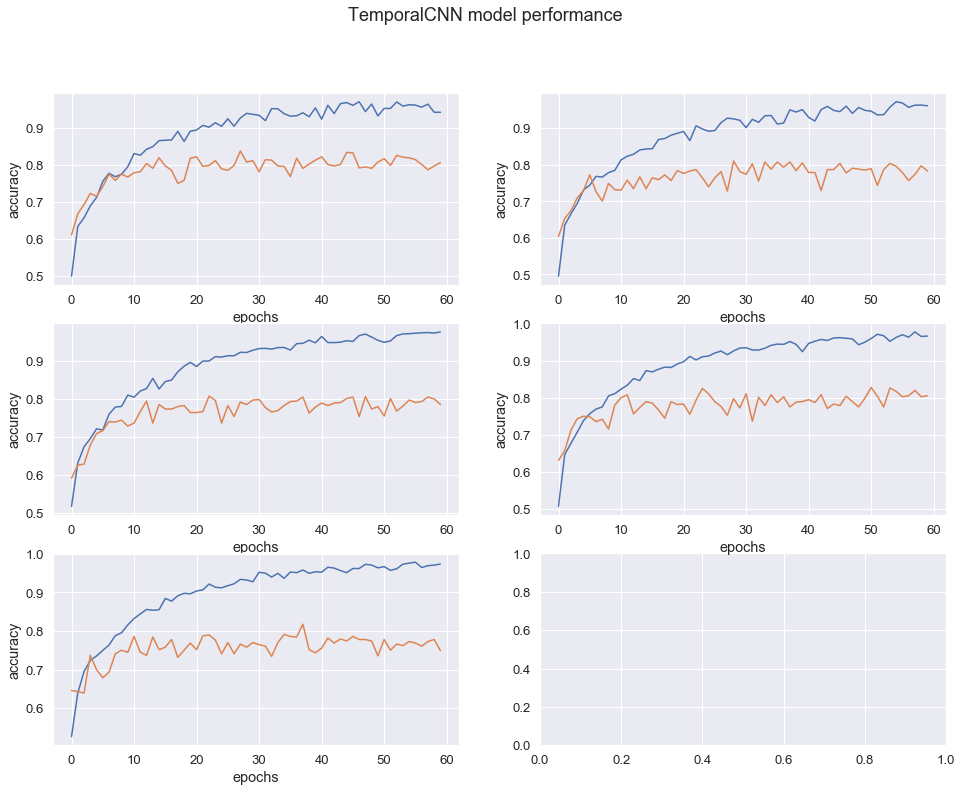

In [673]:
plt.figure()
plt.subplots(3,2, figsize=(16,12))
plt.suptitle('TemporalCNN model performance', fontsize=18)
for i, hist in enumerate(hist_Tcnn_valid_32):
    plt.subplot(3,2,i+1)
    plt.plot(hist.history['acc'], label='train')
    plt.plot(hist.history['val_acc'], label='valid')
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    sns.set(font_scale=1.2)
plt.savefig("Tcnn_valid_bs32.png", dpi=200)
plt.show()

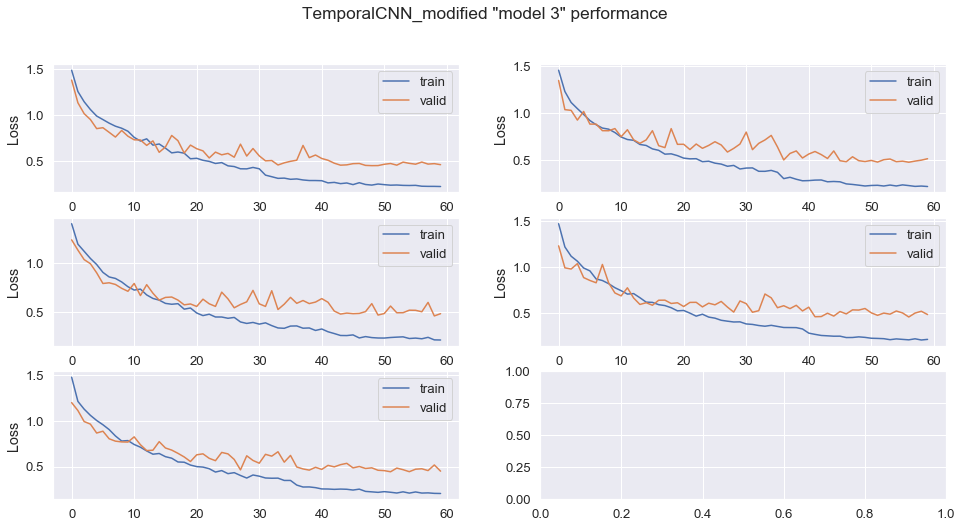

In [683]:
plt.subplots(3,2, figsize=(16,8))
plt.suptitle('TemporalCNN_modified "model 3" performance')
for i, hist in enumerate(hist_pack):
    plt.subplot(3,2,i+1)
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='valid')
    #plt.title('Fold '+str(i+1))
    plt.legend()
    plt.ylabel('Loss')
plt.show()

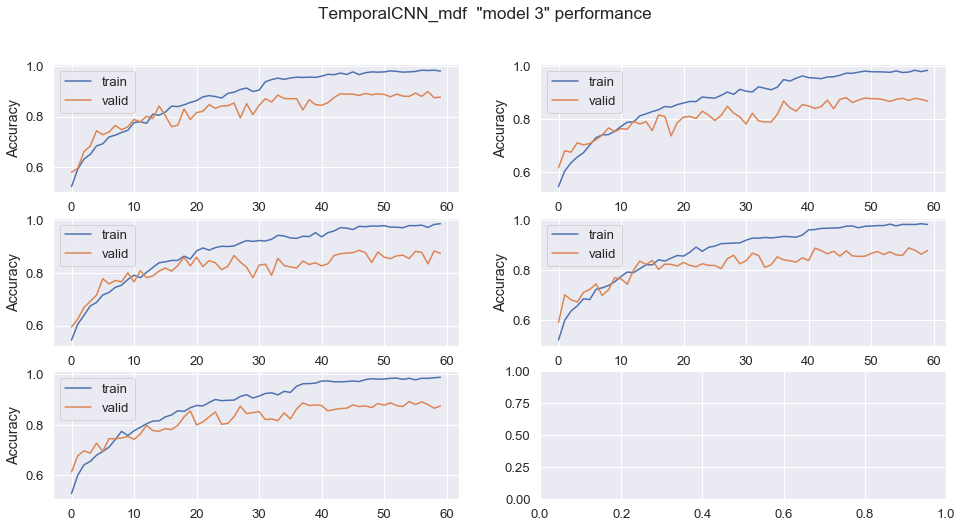

In [689]:
plt.subplots(3,2, figsize=(16,8))
plt.suptitle('TemporalCNN_mdf  "model 3" performance')
for i, hist in enumerate(hist_pack):
    plt.subplot(3,2,i+1)
    plt.plot(hist.history['acc'], label='train')
    plt.plot(hist.history['val_acc'], label='valid')
    plt.ylabel('Accuracy')
    plt.legend()
    if i>4:
        plt.xlabel("epochs")
plt.savefig("TCNN_mdf_perfm.png", dpi=200)
plt.show()

In [638]:
for i, model in enumerate(models_pack):
    model = models_pack[i]
    model.save('model_'+str(i)+'_Tcnn.h5')

In [688]:
# predicting surfaces of test data
yhats = [model.predict([ts_orient, ts_velocity, ts_acceler]) for model in models_pack]

#predicting surface of test data using saved best weights
#yhats=[]
#for model in models_pack:
#    model.load_weights('model_Tcnn_mdf'+str(i)+'.hdf5')
#    yhats.append(model.predict([ts_orient, ts_velocity, ts_acceler]))
    
#save it as an array
yhats = np.array(yhats)
#check shape (5, 3810, 9)
print('yhats shape : ',yhats.shape)
#sum probabilities from 5 folds for each series and surface
summed = np.sum(yhats, axis=0)
#get the surface with highest frequency voted by 5 folds
y_test_pred = np.argmax(summed, axis=1)
# saving results to submit to Kaggle competition 
submission = pd.read_csv('sample_submission.csv')
submission['surface'] = le.inverse_transform(y_test_pred)
submission.to_csv('submission_cnn_mdf.csv', index=False)
#submission.head(20)

yhats shape :  (5, 3816, 9)


In [696]:
#performance of TemporalCNN_red
predictions = np.argmax(pred_val,axis=1)
print('accuracy score ',accuracy_score(predictions,targets))
print('F1 score by weighting classes "macro" :',f1_score(predictions, targets, average='macro'))
display(confusion_matrix(predictions, targets))

accuracy score  0.873753280839895
F1 score by weighting classes "macro" : 0.8643276289843109


array([[159,  12,   2,   0,   2,   1,   5,   3,   8],
       [  9, 637,  21,   0,  20,   8,   6,  23,  18],
       [  7,  40, 304,   0,  11,  11,   0,  10,  12],
       [  0,   0,   1,  17,   0,   0,   2,   0,   1],
       [  0,  19,   3,   0, 261,   1,   0,   0,   1],
       [  6,  30,   7,   0,   1, 686,   9,  11,  13],
       [  3,   2,   1,   1,   0,   8, 270,   2,   0],
       [  0,  25,   9,   0,   4,   3,   1, 458,  17],
       [  5,  14,  15,   3,   9,  14,   4,   7, 537]], dtype=int64)

In [150]:
# perfect fit.
display(confusion_matrix(targets, targets))

array([[189,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 779,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 363,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  21,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 308,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 732,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 297,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 514,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 607]], dtype=int64)


Below I intend to use __Full CNN__ architecture as described in the paper 
H. Ismail Fawaz, G. Forestier, J. Weber, L. Idoumghar, P. Muller: "Deep learning for time series classification: a review",  arXiv:1809.04356 


In [ ]:
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)
    
    model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss', 
save_best_only=True)
    
    file_path = self.output_directory+'best_model.hdf5' 
    
    model.fit(x_train, y_train, batch_size=mini_batch_size, epochs=nb_epochs,
                verbose=self.verbose, validation_data=(x_val,y_val), callbacks=[reduce_lr,model_checkpoint])

    model = keras.models.load_model(self.output_directory+'best_model.hdf5')
    
    

In [636]:
def FullyCNN(num_filters, input_shape):
    input_data = Input(shape=input_shape)
    
    c1 = Conv1D(filters = num_filters, kernel_size = 8, padding = 'valid')(input_data)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    
    c2 = Conv1D(filters = num_filters, kernel_size = 5, padding = 'valid')(c1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    
    c3 = Conv1D(filters = 2*num_filters, kernel_size = 3, padding = 'valid')(c2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    
    c4 = Conv1D(filters = 2*num_filters, kernel_size = 3, padding = 'valid')(c3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    
    gap_layer = GlobalAveragePooling1D()(c4)
    output = Dense(9, activation= 'softmax', activity_regularizer=regularizers.l2(0.01))(gap_layer)
    
    #create Model instance
    FCN_model = Model(inputs = input_data, outputs = output)
    
    #compile the model
    
    optimizer=optimizers.Adam(lr=0.0005)
    FCN_model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
                      metrics=['accuracy'])
    
    return FCN_model
    

In [650]:
fcn_model = FullyCNN(32, (128, 10))
fcn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_78 (InputLayer)        (None, 128, 10)           0         
_________________________________________________________________
conv1d_396 (Conv1D)          (None, 121, 32)           2592      
_________________________________________________________________
batch_normalization_406 (Bat (None, 121, 32)           128       
_________________________________________________________________
activation_359 (Activation)  (None, 121, 32)           0         
_________________________________________________________________
conv1d_397 (Conv1D)          (None, 117, 32)           5152      
_________________________________________________________________
batch_normalization_407 (Bat (None, 117, 32)           128       
_________________________________________________________________
activation_360 (Activation)  (None, 117, 32)           0         
__________

In [652]:
# setting epochs and batch size
epochs = 55
batch_size = 32

#store model, history of epochs, scores and predictions on validatioin folds
models_pack=[]
hist_pack = []
scores=[]
scores_f1=[]
pred_val = np.zeros((targets.shape[0],9))

#groups = y_train['group_id'] defined when y_train.csv is read 
skf = StratifiedKFold(n_splits=5)
random.seed(27)
i=0
for train_index, valid_index in skf.split(tr, targets):
    i += 1
    print('Fold: ', i)
    xx_train, xx_valid = tr[train_index], tr[valid_index]
    y_train, y_valid = targets_enc[train_index], targets_enc[valid_index]
        
    
    # train the model
    num_features = 128
    input_shape = (128,10)
    model = FullyCNN(num_features, input_shape)
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=0.0001)
    checkpointer = ModelCheckpoint(filepath='model_fullcnn'+str(i)+'.hdf5', verbose=1, 
                               save_best_only=True)
    
    hist = model.fit(xx_train, y_train, batch_size=batch_size, epochs=epochs,
               validation_data = (xx_valid, y_valid), verbose=2, callbacks=[reduce_lr])
    
    #scoring and evaluating
    score = model.evaluate(xx_valid, y_valid, verbose=0)
    
    pred_val[valid_index,:]= (model.predict(xx_valid))
    predictions = (model.predict(xx_valid))
    predictions = [np.argmax(entry) for entry in predictions]
    print('F1 score of fold {} is {:2.5f}'.format(i, f1_score(predictions,np.argmax((y_valid),axis=1), average='macro')))

    labels = [np.argmax(vector) for vector in (y_valid)]
    display(confusion_matrix(labels, predictions))
    
    #save results of each model and cross-validation fold
    scores_f1.append(f1_score(predictions,np.argmax((y_valid),axis=1), average='macro'))
    scores.append(score)
    models_pack.append(model)
    hist_pack.append(hist)
print('F1 score of the model: ',f1_score(targets, np.argmax(pred_val,axis=1), average = 'macro'))



Fold:  1
Train on 3044 samples, validate on 766 samples
Epoch 1/55
 - 110s - loss: 1.5141 - acc: 0.5030 - val_loss: 2.1714 - val_acc: 0.3629
Epoch 2/55
 - 37s - loss: 1.2990 - acc: 0.5913 - val_loss: 1.6690 - val_acc: 0.3995
Epoch 3/55
 - 32s - loss: 1.2071 - acc: 0.6163 - val_loss: 1.8502 - val_acc: 0.4373
Epoch 4/55
 - 32s - loss: 1.1791 - acc: 0.6353 - val_loss: 1.7399 - val_acc: 0.3616
Epoch 5/55
 - 32s - loss: 1.1577 - acc: 0.6373 - val_loss: 1.4743 - val_acc: 0.4700
Epoch 6/55
 - 33s - loss: 1.1022 - acc: 0.6583 - val_loss: 1.5556 - val_acc: 0.4752
Epoch 7/55
 - 32s - loss: 1.0674 - acc: 0.6741 - val_loss: 1.5305 - val_acc: 0.4791
Epoch 8/55
 - 31s - loss: 1.0791 - acc: 0.6639 - val_loss: 1.3308 - val_acc: 0.5601
Epoch 9/55
 - 32s - loss: 1.0504 - acc: 0.6813 - val_loss: 1.4691 - val_acc: 0.4896
Epoch 10/55
 - 32s - loss: 1.0426 - acc: 0.6764 - val_loss: 1.5137 - val_acc: 0.5157
Epoch 11/55
 - 31s - loss: 0.9915 - acc: 0.6961 - val_loss: 1.4875 - val_acc: 0.4452
Epoch 12/55
 - 32

array([[ 24,   6,   2,   0,   2,   3,   0,   0,   1],
       [  4, 134,   1,   0,   2,   1,   0,  10,   4],
       [  4,   2,  22,   0,  15,   7,   1,   0,  22],
       [  0,   0,   0,   2,   0,   0,   2,   0,   1],
       [  4,   4,   1,   0,  45,   1,   0,   3,   4],
       [  0,   5,   4,   0,   0, 117,   9,   1,  11],
       [  0,   0,   0,   0,   0,   0,  60,   0,   0],
       [  0,  16,   2,   0,  11,   7,   1,  64,   2],
       [  6,   6,   1,   0,   4,   0,   0,  34,  71]], dtype=int64)

Fold:  2
Train on 3045 samples, validate on 765 samples
Epoch 1/55
 - 109s - loss: 1.5703 - acc: 0.4864 - val_loss: 1.5339 - val_acc: 0.4980
Epoch 2/55
 - 33s - loss: 1.3297 - acc: 0.5658 - val_loss: 1.4675 - val_acc: 0.5007
Epoch 3/55
 - 29s - loss: 1.2636 - acc: 0.5947 - val_loss: 1.3745 - val_acc: 0.4993
Epoch 4/55
 - 29s - loss: 1.2154 - acc: 0.6016 - val_loss: 1.3063 - val_acc: 0.5778
Epoch 5/55
 - 29s - loss: 1.1452 - acc: 0.6263 - val_loss: 1.1955 - val_acc: 0.6131
Epoch 6/55
 - 30s - loss: 1.1098 - acc: 0.6437 - val_loss: 1.2643 - val_acc: 0.5843
Epoch 7/55
 - 30s - loss: 1.0854 - acc: 0.6532 - val_loss: 1.2198 - val_acc: 0.5817
Epoch 8/55
 - 30s - loss: 1.0791 - acc: 0.6650 - val_loss: 1.1552 - val_acc: 0.6092
Epoch 9/55
 - 30s - loss: 1.0639 - acc: 0.6581 - val_loss: 1.1877 - val_acc: 0.6105
Epoch 10/55
 - 30s - loss: 1.0212 - acc: 0.6837 - val_loss: 1.0771 - val_acc: 0.6954
Epoch 11/55
 - 30s - loss: 1.0116 - acc: 0.6857 - val_loss: 1.0539 - val_acc: 0.6980
Epoch 12/55
 - 30

array([[ 30,   4,   0,   0,   0,   1,   0,   0,   3],
       [ 11, 134,   1,   0,   1,   1,   1,   6,   1],
       [  2,   7,  50,   2,   4,   0,   0,   3,   5],
       [  0,   0,   0,   3,   0,   0,   0,   0,   1],
       [  6,  10,   1,   0,  44,   0,   0,   0,   1],
       [  0,  11,   0,   0,   4, 119,   8,   1,   4],
       [  0,   0,   0,   0,   0,   0,  57,   0,   3],
       [  1,  14,   4,   0,   0,   2,   3,  78,   1],
       [  6,  10,   7,   0,   0,   1,   0,  13,  85]], dtype=int64)

Fold:  3
Train on 3048 samples, validate on 762 samples
Epoch 1/55
 - 109s - loss: 1.5857 - acc: 0.4754 - val_loss: 1.4532 - val_acc: 0.4882
Epoch 2/55
 - 32s - loss: 1.3506 - acc: 0.5502 - val_loss: 1.2519 - val_acc: 0.5643
Epoch 3/55
 - 30s - loss: 1.3029 - acc: 0.5676 - val_loss: 1.2958 - val_acc: 0.5748
Epoch 4/55
 - 30s - loss: 1.2145 - acc: 0.5955 - val_loss: 1.2067 - val_acc: 0.5827
Epoch 5/55
 - 31s - loss: 1.1748 - acc: 0.6168 - val_loss: 1.1605 - val_acc: 0.6562
Epoch 6/55
 - 30s - loss: 1.1586 - acc: 0.6283 - val_loss: 1.1324 - val_acc: 0.6404
Epoch 7/55
 - 30s - loss: 1.0977 - acc: 0.6476 - val_loss: 1.0843 - val_acc: 0.6732
Epoch 8/55
 - 30s - loss: 1.0862 - acc: 0.6562 - val_loss: 1.0946 - val_acc: 0.6378
Epoch 9/55
 - 31s - loss: 1.0844 - acc: 0.6476 - val_loss: 1.0023 - val_acc: 0.6995
Epoch 10/55
 - 30s - loss: 1.0664 - acc: 0.6608 - val_loss: 0.9915 - val_acc: 0.6995
Epoch 11/55
 - 30s - loss: 1.0448 - acc: 0.6624 - val_loss: 1.0787 - val_acc: 0.6680
Epoch 12/55
 - 30

array([[ 26,   5,   0,   0,   0,   2,   0,   2,   3],
       [  6, 125,   2,   0,   4,   8,   2,   7,   2],
       [  0,   2,  47,   0,   1,  10,   0,   9,   4],
       [  0,   0,   0,   3,   0,   1,   0,   0,   0],
       [  0,   3,   0,   0,  58,   0,   0,   0,   1],
       [  0,   3,   0,   1,   0, 135,   1,   1,   5],
       [  0,   0,   0,   0,   0,   1,  56,   1,   1],
       [  0,   4,   0,   0,   0,   1,   0,  96,   2],
       [  1,   0,   2,   1,   0,  11,   0,   0, 106]], dtype=int64)

Fold:  4
Train on 3050 samples, validate on 760 samples
Epoch 1/55
 - 102s - loss: 1.6079 - acc: 0.4695 - val_loss: 1.5060 - val_acc: 0.5316
Epoch 2/55
 - 40s - loss: 1.3439 - acc: 0.5518 - val_loss: 1.4443 - val_acc: 0.5395
Epoch 3/55
 - 31s - loss: 1.2648 - acc: 0.5731 - val_loss: 1.2059 - val_acc: 0.6303
Epoch 4/55
 - 32s - loss: 1.2030 - acc: 0.6013 - val_loss: 1.2034 - val_acc: 0.5908
Epoch 5/55
 - 31s - loss: 1.1721 - acc: 0.6180 - val_loss: 1.1655 - val_acc: 0.6224
Epoch 6/55
 - 31s - loss: 1.1250 - acc: 0.6403 - val_loss: 1.0819 - val_acc: 0.6645
Epoch 7/55
 - 31s - loss: 1.0965 - acc: 0.6479 - val_loss: 1.0154 - val_acc: 0.6934
Epoch 8/55
 - 32s - loss: 1.1022 - acc: 0.6380 - val_loss: 1.0241 - val_acc: 0.7092
Epoch 9/55
 - 31s - loss: 1.0941 - acc: 0.6495 - val_loss: 1.0125 - val_acc: 0.6816
Epoch 10/55
 - 31s - loss: 1.0403 - acc: 0.6702 - val_loss: 1.0454 - val_acc: 0.6645
Epoch 11/55
 - 31s - loss: 1.0420 - acc: 0.6708 - val_loss: 1.2353 - val_acc: 0.5842
Epoch 12/55
 - 32

array([[ 32,   1,   0,   0,   0,   0,   4,   0,   1],
       [  2, 121,   6,   0,   6,   6,   3,   9,   3],
       [  0,   5,  53,   0,   1,   2,   1,  10,   0],
       [  0,   0,   0,   3,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0,  59,   1,   0,   0,   1],
       [  0,   1,   0,   1,   0, 135,   4,   1,   4],
       [  0,   1,   0,   0,   0,   0,  56,   0,   2],
       [  2,   0,   0,   0,   0,   1,   2,  97,   1],
       [  0,   0,   5,   1,   0,  13,   1,   1, 100]], dtype=int64)

Fold:  5
Train on 3053 samples, validate on 757 samples
Epoch 1/55
 - 108s - loss: 1.5971 - acc: 0.4658 - val_loss: 1.3883 - val_acc: 0.5469
Epoch 2/55
 - 34s - loss: 1.3591 - acc: 0.5463 - val_loss: 1.2577 - val_acc: 0.6380
Epoch 3/55
 - 30s - loss: 1.2777 - acc: 0.5784 - val_loss: 1.2725 - val_acc: 0.5429
Epoch 4/55
 - 31s - loss: 1.2252 - acc: 0.6030 - val_loss: 1.3038 - val_acc: 0.5575
Epoch 5/55
 - 31s - loss: 1.1736 - acc: 0.6184 - val_loss: 1.1187 - val_acc: 0.6645
Epoch 6/55
 - 34s - loss: 1.1323 - acc: 0.6423 - val_loss: 1.1264 - val_acc: 0.6169
Epoch 7/55
 - 34s - loss: 1.1051 - acc: 0.6512 - val_loss: 1.0966 - val_acc: 0.6526
Epoch 8/55
 - 30s - loss: 1.0936 - acc: 0.6495 - val_loss: 1.1031 - val_acc: 0.6539
Epoch 9/55
 - 31s - loss: 1.0682 - acc: 0.6649 - val_loss: 0.9989 - val_acc: 0.6764
Epoch 10/55
 - 30s - loss: 1.0413 - acc: 0.6770 - val_loss: 1.0899 - val_acc: 0.6380
Epoch 11/55
 - 30s - loss: 1.0309 - acc: 0.6895 - val_loss: 0.9570 - val_acc: 0.6935
Epoch 12/55
 - 30

array([[ 29,   0,   0,   0,   3,   0,   3,   0,   2],
       [  2, 126,   4,   0,   4,   5,   1,   6,   7],
       [  2,   6,  56,   0,   0,   1,   2,   1,   4],
       [  0,   0,   0,   4,   0,   0,   0,   0,   0],
       [  0,   5,   0,   0,  54,   0,   0,   1,   1],
       [  0,   3,   1,   2,   0, 122,   6,   0,  12],
       [  1,   0,   0,   0,   0,   1,  57,   0,   0],
       [  3,   4,  15,   0,   0,   3,   0,  76,   1],
       [  3,   0,   5,   1,   1,   8,   1,   0, 102]], dtype=int64)

F1 score of the model:  0.7823215076599718


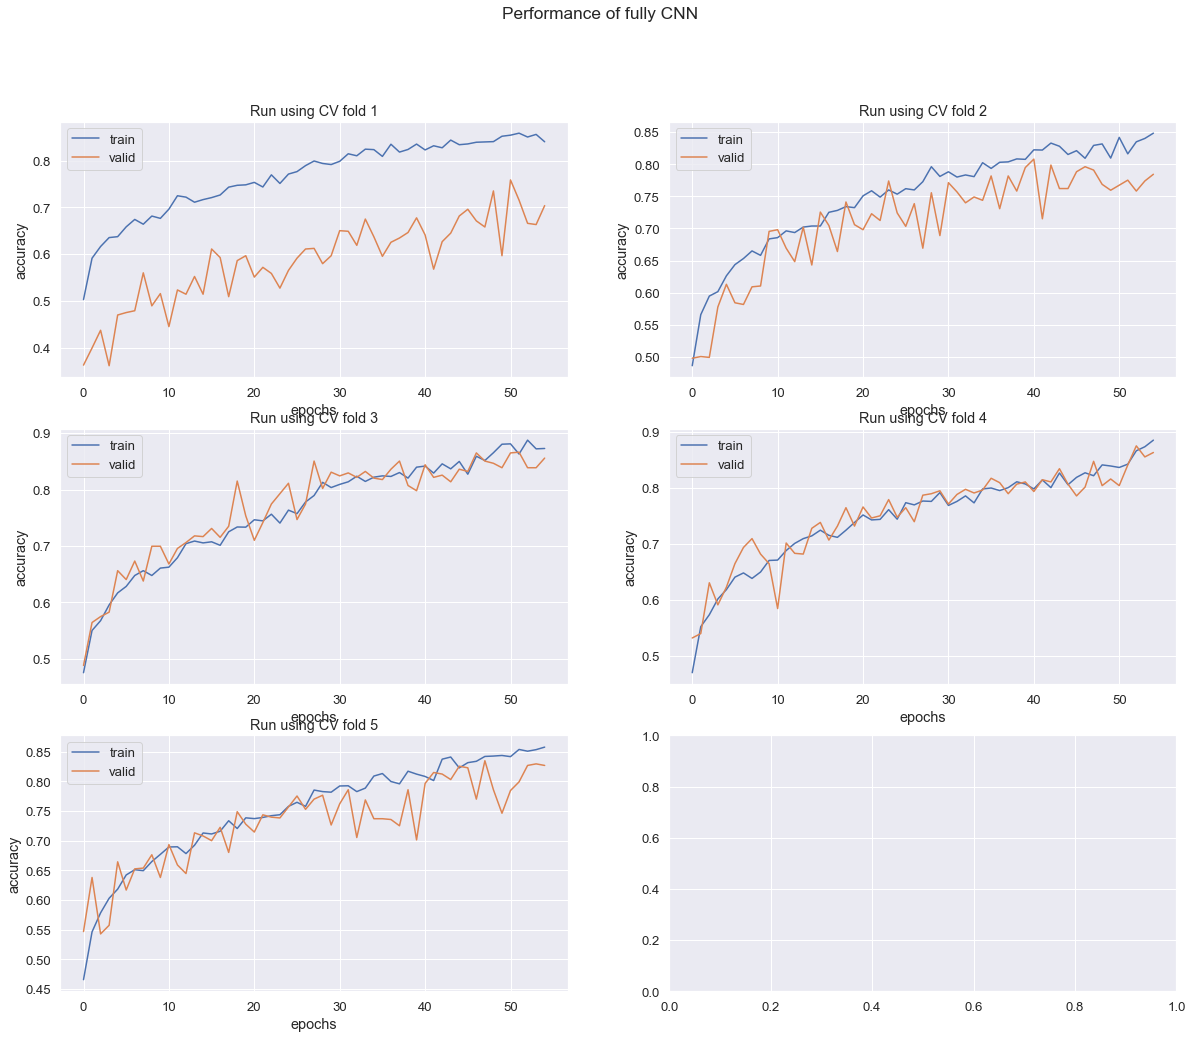

In [668]:
plt.subplots(3,2, figsize=(20,16))
plt.suptitle("Performance of fully CNN")
for i, hist in enumerate(hist_pack):
    plt.subplot(3,2,i+1)
    plt.plot(hist.history['acc'], label='train')
    plt.plot(hist.history['val_acc'], label='valid')
    #plt.title('Run using CV fold '+ str(i+1))
    plt.ylabel('Accuracy')
    plt.legend()
    if i>4:
        plt.xlabel("epochs")
plt.savefig("FCN_performace.png", dpi=200)
plt.show()

In [662]:
np.array(scores)[:,1]
accuracy_score(np.argmax(pred_val,axis=1),targets)
f1_score(np.argmax(pred_val,axis=1),targets,average='macro')

0.7823215076599718

In [663]:
hist_FCN = hist_pack

In [666]:
# predicting surfaces of test data
yhats = [model.predict(ts) for model in models_pack]
#save it as an array
yhats = np.array(yhats)
#check shape (5, 3810, 9)
print('yhats shape : ',yhats.shape)
#sum probabilities from 5 folds for each series and surface
summed = np.sum(yhats, axis=0)
#get the surface with highest frequency voted by 5 folds
y_test_pred = np.argmax(summed, axis=1)
# saving results to submit to Kaggle competition 
submission = pd.read_csv('sample_submission.csv')
submission['surface'] = le.inverse_transform(y_test_pred)
submission.to_csv('submission_FullCNN.csv', index=False)
submission.head(20)

yhats shape :  (4, 3816, 9)


,series_id,surface
0,0,tiled
1,1,soft_tiles
2,2,tiled
3,3,wood
4,4,soft_tiles
5,5,concrete
6,6,fine_concrete
7,7,concrete
8,8,wood
9,9,wood
